In [3]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [4]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [6]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


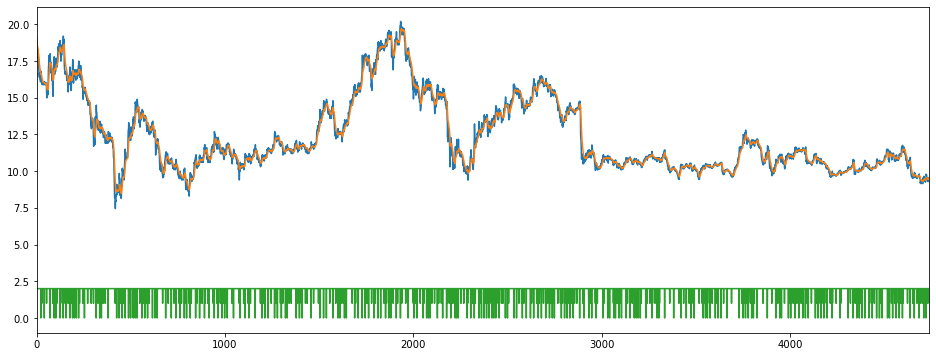

In [7]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [8]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0

In [32]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
willr_data.shape

(4715, 25, 1)

In [34]:
price_data = np.array(price_data)
price_data.shape

(4715, 25, 1)

In [35]:
ema_data = np.array(ema_data)
ema_data.shape

(4715, 25, 1)

In [36]:
obv_data = np.array(obv_data)
obv_data.shape

(4715, 25, 1)

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [38]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4715, 64, 64, 1)

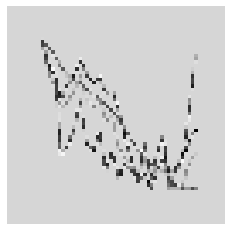

In [39]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [40]:
X = X/255

In [41]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [42]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [43]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [170]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [171]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.352826510721248, 1: 7.396078431372549, 2: 0.3664626445156903}
Epoch 1/200
30/30 [==============================] - 3s 95ms/step - loss: 0.2464 - accuracy: 0.3539 - mse: 1.6515 - weighted_accuracy: 0.3398 - weighted_mse: 1.7282 - val_loss: 0.2005 - val_accuracy: 0.0456 - val_mse: 0.8944 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.8944
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2050 - accuracy: 0.3616 - mse: 1.1518 - weighted_accuracy: 0.3278 - weighted_mse: 1.1675 - val_loss: 0.1901 - val_accuracy: 0.3733 - val_mse: 0.9975 - val_weighted_accuracy: 0.3733 - val_weighted_mse: 0.9975
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2049 - accuracy: 0.3396 - mse: 1.1597 - weighted_accuracy: 0.3440 - weighted_mse: 1.1719 - val_loss: 0.1948 - val_accuracy: 0.1198 - val_mse: 0.9429 - val_weighted_accuracy: 0.1198 - val_weighted_mse: 0.9429
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2044 - 

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1831 - accuracy: 0.1702 - mse: 1.2164 - weighted_accuracy: 0.5083 - weighted_mse: 1.1990 - val_loss: 0.1906 - val_accuracy: 0.0626 - val_mse: 1.0341 - val_weighted_accuracy: 0.0626 - val_weighted_mse: 1.0341
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1846 - accuracy: 0.1596 - mse: 1.2477 - weighted_accuracy: 0.4840 - weighted_mse: 1.2121 - val_loss: 0.2010 - val_accuracy: 0.0689 - val_mse: 1.0482 - val_weighted_accuracy: 0.0689 - val_weighted_mse: 1.0482
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1812 - accuracy: 0.1707 - mse: 1.2557 - weighted_accuracy: 0.5290 - weighted_mse: 1.2237 - val_loss: 0.1912 - val_accuracy: 0.0753 - val_mse: 1.1001 - val_weighted_accuracy: 0.0753 - val_weighted_mse: 1.1001
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1795 - accuracy: 0.1726 - mse: 1.2821 - weighted_accuracy: 0.5315 - wei

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1545 - accuracy: 0.1877 - mse: 1.4082 - weighted_accuracy: 0.6261 - weighted_mse: 1.3844 - val_loss: 0.1916 - val_accuracy: 0.2195 - val_mse: 1.3418 - val_weighted_accuracy: 0.2195 - val_weighted_mse: 1.3418
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1537 - accuracy: 0.1856 - mse: 1.4345 - weighted_accuracy: 0.6216 - weighted_mse: 1.4331 - val_loss: 0.1983 - val_accuracy: 0.1644 - val_mse: 1.1567 - val_weighted_accuracy: 0.1644 - val_weighted_mse: 1.1567
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1521 - accuracy: 0.1853 - mse: 1.4599 - weighted_accuracy: 0.6235 - weighted_mse: 1.4794 - val_loss: 0.1950 - val_accuracy: 0.1835 - val_mse: 1.2213 - val_weighted_accuracy: 0.1835 - val_weighted_mse: 1.2213
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1526 - accuracy: 0.1996 - mse: 1.4318 - weighted_accuracy: 0.6361 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1338 - accuracy: 0.3128 - mse: 1.6917 - weighted_accuracy: 0.7036 - weighted_mse: 1.7954 - val_loss: 0.1883 - val_accuracy: 0.3468 - val_mse: 1.4740 - val_weighted_accuracy: 0.3468 - val_weighted_mse: 1.4740
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1329 - accuracy: 0.3332 - mse: 1.7297 - weighted_accuracy: 0.7092 - weighted_mse: 1.8507 - val_loss: 0.1867 - val_accuracy: 0.3457 - val_mse: 1.4942 - val_weighted_accuracy: 0.3457 - val_weighted_mse: 1.4942
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1295 - accuracy: 0.3335 - mse: 1.7732 - weighted_accuracy: 0.7241 - weighted_mse: 1.9181 - val_loss: 0.1881 - val_accuracy: 0.3415 - val_mse: 1.4476 - val_weighted_accuracy: 0.3415 - val_weighted_mse: 1.4476
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1325 - accuracy: 0.3364 - mse: 1.7721 - weighted_accuracy: 0.6992 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1185 - accuracy: 0.5050 - mse: 2.1827 - weighted_accuracy: 0.7555 - weighted_mse: 2.7099 - val_loss: 0.1680 - val_accuracy: 0.5631 - val_mse: 1.6756 - val_weighted_accuracy: 0.5631 - val_weighted_mse: 1.6756
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1138 - accuracy: 0.5236 - mse: 2.1780 - weighted_accuracy: 0.7826 - weighted_mse: 2.7135 - val_loss: 0.1698 - val_accuracy: 0.5249 - val_mse: 1.8827 - val_weighted_accuracy: 0.5249 - val_weighted_mse: 1.8827
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1139 - accuracy: 0.5204 - mse: 2.2761 - weighted_accuracy: 0.7760 - weighted_mse: 2.8297 - val_loss: 0.1624 - val_accuracy: 0.6045 - val_mse: 1.9655 - val_weighted_accuracy: 0.6045 - val_weighted_mse: 1.9655
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1152 - accuracy: 0.5239 - mse: 2.2312 - weighted_accuracy: 0.7754 - 

Epoch 173/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0979 - accuracy: 0.6766 - mse: 3.0918 - weighted_accuracy: 0.8276 - weighted_mse: 4.4661 - val_loss: 0.1336 - val_accuracy: 0.7381 - val_mse: 2.4424 - val_weighted_accuracy: 0.7381 - val_weighted_mse: 2.4424
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0968 - accuracy: 0.6962 - mse: 3.1411 - weighted_accuracy: 0.8329 - weighted_mse: 4.5560 - val_loss: 0.1340 - val_accuracy: 0.7444 - val_mse: 2.4910 - val_weighted_accuracy: 0.7444 - val_weighted_mse: 2.4910
Epoch 175/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0974 - accuracy: 0.6792 - mse: 3.2276 - weighted_accuracy: 0.8211 - weighted_mse: 4.6812 - val_loss: 0.1340 - val_accuracy: 0.7413 - val_mse: 2.5402 - val_weighted_accuracy: 0.7413 - val_weighted_mse: 2.5402
Epoch 176/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0946 - accuracy: 0.7049 - mse: 3.2160 - weighted_accuracy: 0.851

In [172]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11611326038837433
Test accuracy: 0.8186638355255127


In [173]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.7528375  -2.8668208  -0.1927535 ]
 [-1.8541448  -1.8542544  -0.06703381]
 [-1.2724056  -1.8050727  -0.0728074 ]
 ...
 [-0.37598842 -2.7137177  -0.40887782]
 [-0.8695067  -2.3621902  -0.15897049]
 [-2.6570408  -1.502164   -0.05709609]]


Counter({2: 831, 0: 56, 1: 56})

In [174]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 857, 0: 43, 1: 43})

In [175]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 943
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 34
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 38
actual holds but predicted buy: 46
actual holds but predicted sell: 52
actual predicted holds: 759
Percentage buys correct: 20.930232558139537%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 88.56476079346558%
actual buys: 43
actual sells: 43
actual holds: 857


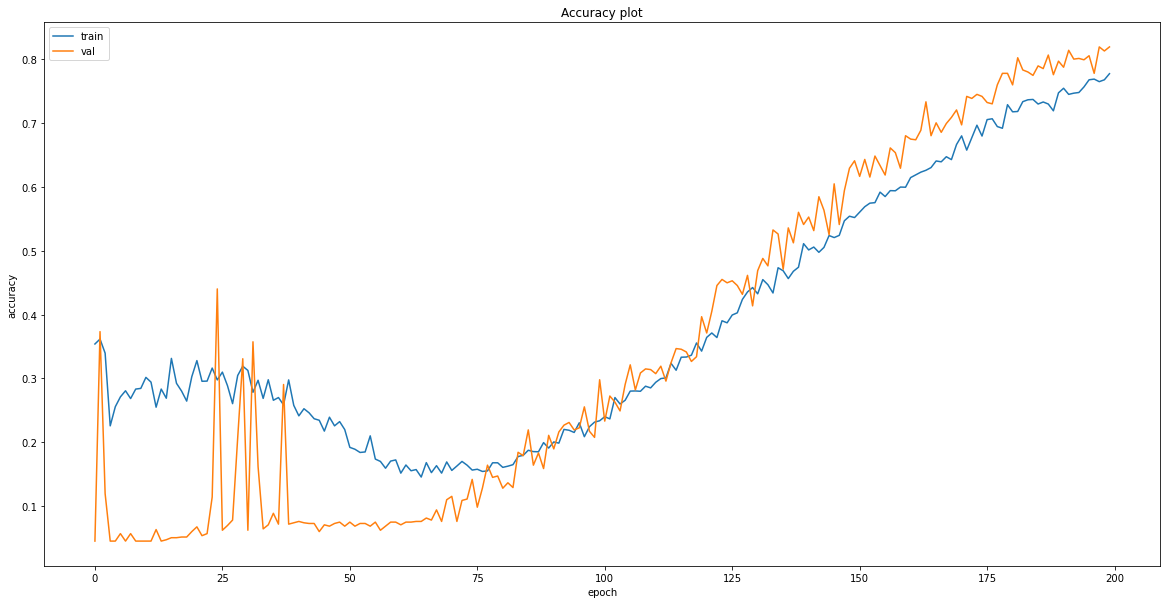

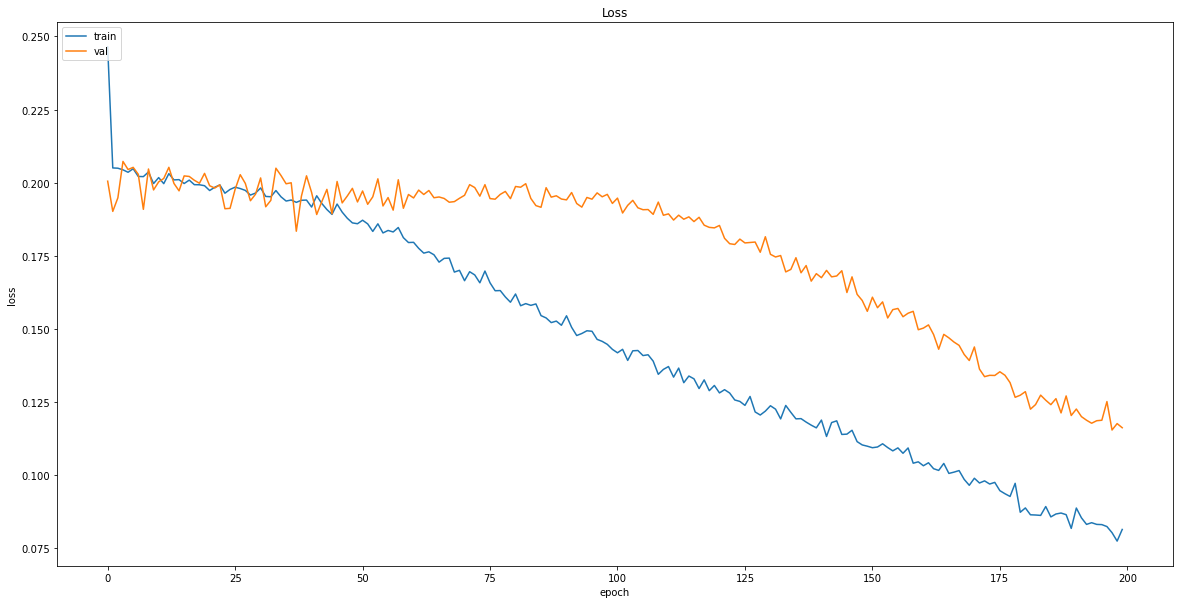

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [177]:
# Save model
model.save("models/{}".format('Singapore_Airlines_image_cnn_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/Singapore_Airlines_image_cnn_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [178]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


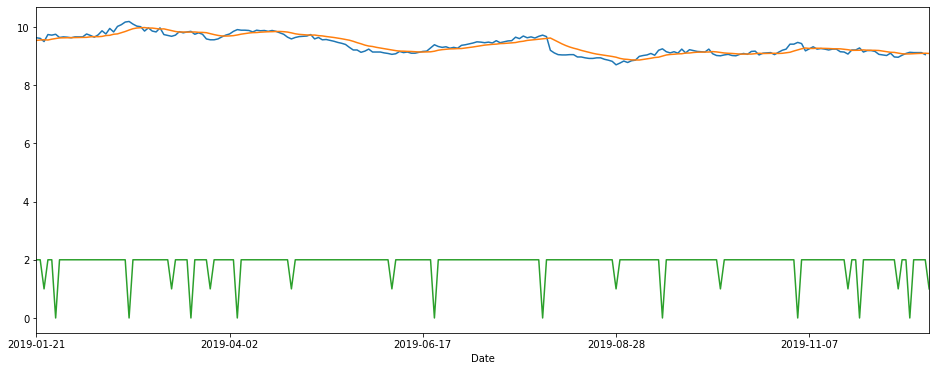

In [179]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [180]:
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
df2.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


In [181]:
df2 = df2.iloc[-10:]
df2.head(20)

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2018-12-07         9.34  9.503724 -76.190390 -86008167.0     2.0
2018-12-10         9.43  9.492382 -61.904654 -83713267.0     1.0
2018-12-11         9.29  9.461246 -84.126926 -84539167.0     2.0
2018-12-12         9.33  9.441054 -87.500043 -83479567.0     2.0
2018-12-13         9.54  9.456277 -50.000000 -80918667.0     2.0
2018-12-14         9.52  9.466080 -53.571343 -82078567.0     2.0
2018-12-17         9.33  9.445145 -87.500043 -84305791.0     2.0
2018-12-18         9.45  9.445892 -64.814890 -82764591.0     2.0
2018-12-19         9.39  9.437293 -75.925903 -84460291.0     2.0
2018-12-20         9.37  9.426940 -75.000054 -85913091.0     2.0

In [182]:
df2 = pd.concat([df2,df])
df2.head(20)

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2018-12-07         9.34  9.503724 -76.190390 -86008167.0     2.0
2018-12-10         9.43  9.492382 -61.904654 -83713267.0     1.0
2018-12-11         9.29  9.461246 -84.126926 -84539167.0     2.0
2018-12-12         9.33  9.441054 -87.500043 -83479567.0     2.0
2018-12-13         9.54  9.456277 -50.000000 -80918667.0     2.0
2018-12-14         9.52  9.466080 -53.571343 -82078567.0     2.0
2018-12-17         9.33  9.445145 -87.500043 -84305791.0     2.0
2018-12-18         9.45  9.445892 -64.814890 -82764591.0     2.0
2018-12-19         9.39  9.437293 -75.925903 -84460291.0     2.0
2018-12-20         9.37  9.426940 -75.000054 -85913091.0     2.0
2019-01-21         9.59  9.538960 -32.758553   6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007   7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362   7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822   6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884   8160300.0     2.0
2019-01-28         9.72  9.602493 -20.000000   7026900.0     0.0
2019-01-29         9.75  9.625186 -15.000083   7689700.0     2.0
2019-01-30         9.64  9.627465 -51.515038   6232300.0     2.0
2019-01-31         9.66  9.632471 -45.454598   7395400.0     2.0
2019-02-01         9.65  9.635167 -48.484962   5664000.0     2.0

In [183]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [184]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [185]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [186]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [187]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [188]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1110 - accuracy: 0.8257 - mean_squared_error: 3.3209 - weighted_accuracy: 0.8257 - weighted_mean_squared_error: 3.3209
Test loss: 0.11104346811771393
Test accuracy: 0.8256880640983582


In [189]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 15, 2: 190, 1: 13})

In [190]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [191]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-191-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-191-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-191-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2019-02-11         9.71  9.662247 -15.151533  6464788.0     2.0            0   
2019-02-12         9.65  9.669594 -30.303065  5675088.0     2.0            2   
2019-02-13         9.73  9.666579 -48.484962  4337188.0     2.0            2   
2019-02-14         9.87  9.676336 -32.000351  5826588.0     2.0            2   
2019-02-15         9.76  9.706131  -6.250130  8384988.0     2.0            2   

            actual  
Date                
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2  
2019-02-15       2

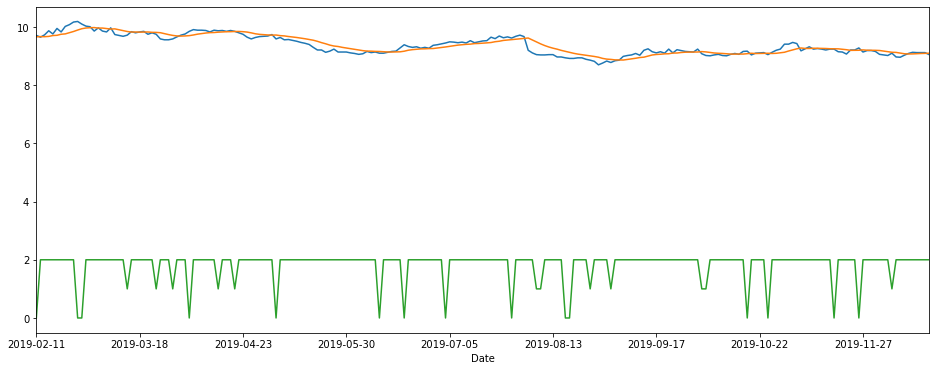

In [192]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

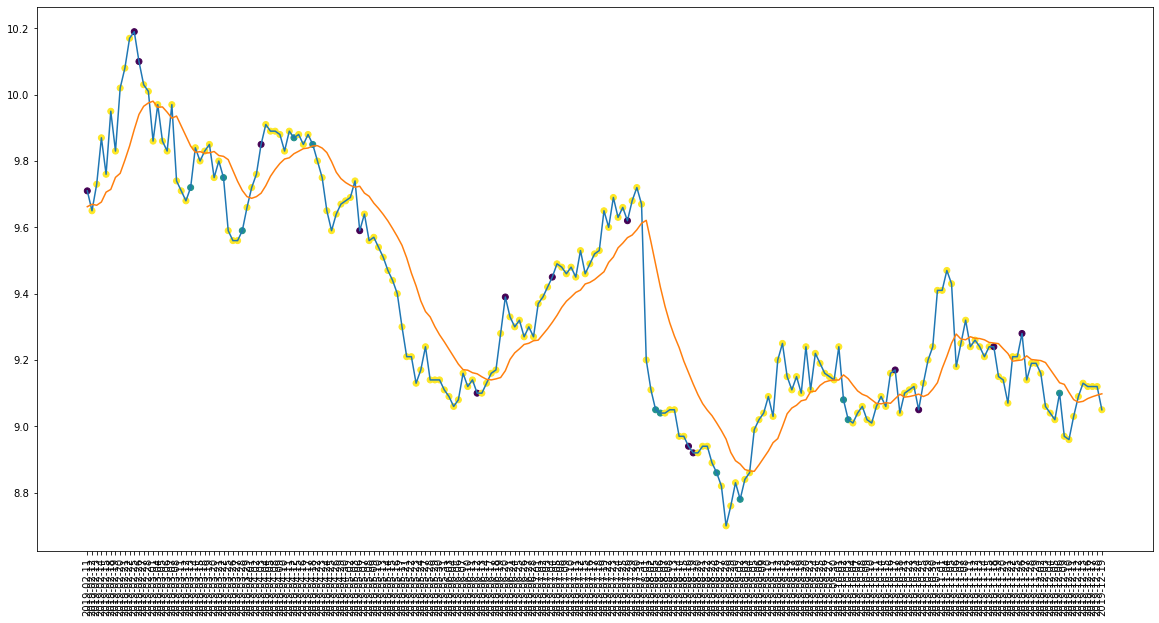

In [193]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

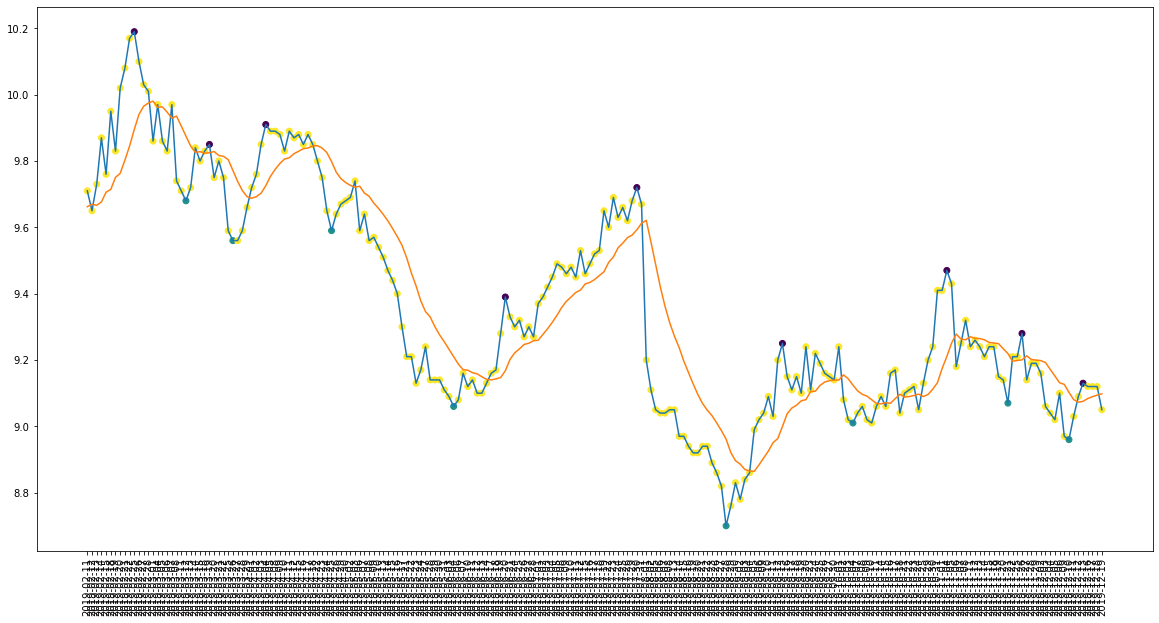

In [194]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [195]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 12
actual holds but predicted sell: 12
actual predicted holds: 176
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 88.0%
actual buys: 9
actual sells: 9
actual holds: 200


In [196]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 58.333333333333336%
Percentage sells correct: 40.0%
Percentage holds correct: 78.94736842105263%


In [197]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.720000267028807
Shares owned at the moment: 1025
Cash capital at the moment: $9.60147554278592


Stop Loss Activated!

Share price: $9.4399995803833
Shares owned at the moment: 0
Cash capital at the moment: $9658.992046618463


Share price: $9.050000190734863
Shares owned at the moment: 1064
Cash capital at the moment: $3.311543118477857


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $9234.655140734674


Share price: $8.779999732971191
Shares owned at the moment: 1048
Cash capital at the moment: $7.911461350442551


Price increase from previously bought: 5.404897525048202%
Share price: $9.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9706.60622227383


Share price: $9.100000381469727
Shares owned at the moment: 1063
Cash capital at the moment: $6.704240656377806




Capital at the end of test period: $9600.399030349972
profit gained: -3.996009696500278%


In [198]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


### Recession

In [211]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


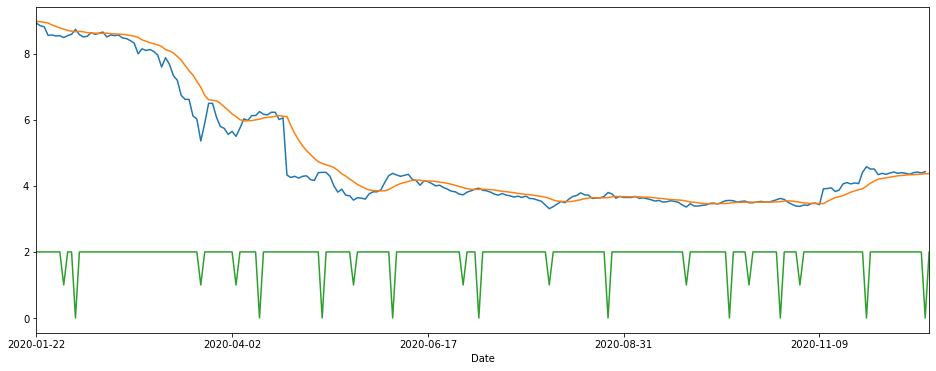

In [212]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [213]:
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])

In [214]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [215]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [216]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [217]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [218]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [219]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1314 - accuracy: 0.7814 - mean_squared_error: 3.6482 - weighted_accuracy: 0.7814 - weighted_mean_squared_error: 3.6482
Test loss: 0.13135911524295807
Test accuracy: 0.7813953757286072


In [220]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 184, 0: 11, 1: 20})

In [221]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [222]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-222-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-222-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-222-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-12         8.64  8.623953 -86.440694 -2356000.0     2.0            2   
2020-02-13         8.59  8.626421 -61.224363  -575600.0     2.0            2   
2020-02-14         8.62  8.620818 -64.102508 -2132700.0     2.0            2   
2020-02-17         8.66  8.620692 -45.161340  -798700.0     2.0            2   
2020-02-18         8.51  8.626740 -32.258144   341600.0     2.0            0   

            actual  
Date                
2020-02-12       2  
2020-02-13       2  
2020-02-14       2  
2020-02-17       2  
2020-02-18       2

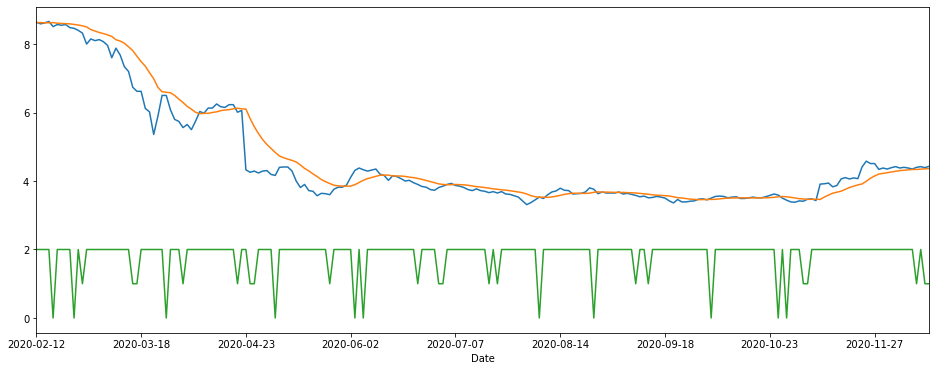

In [223]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

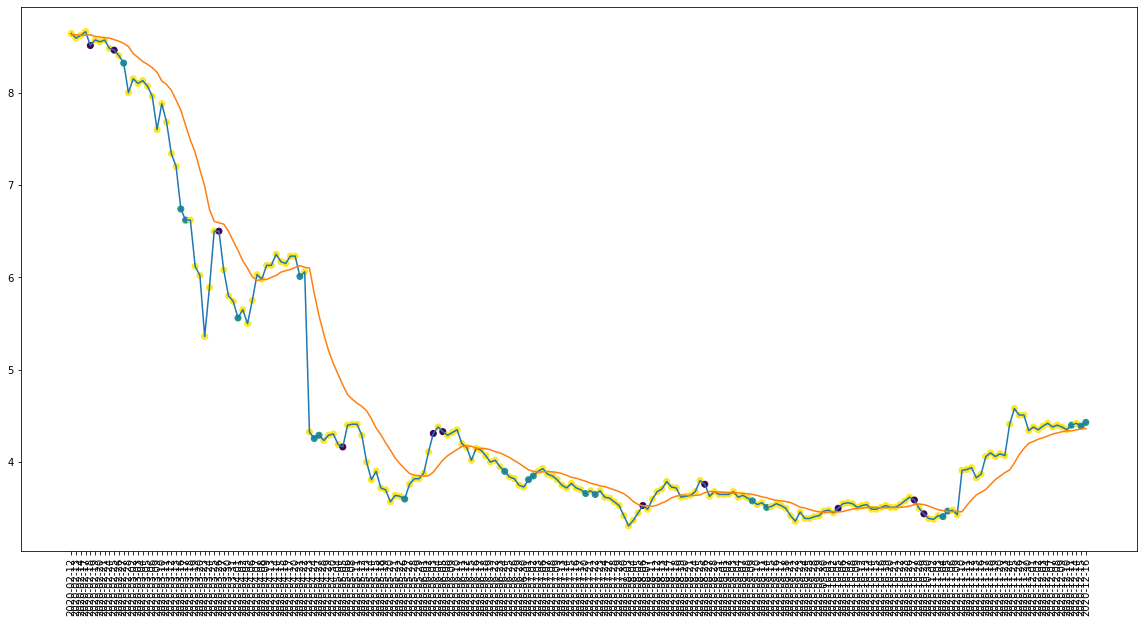

In [224]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

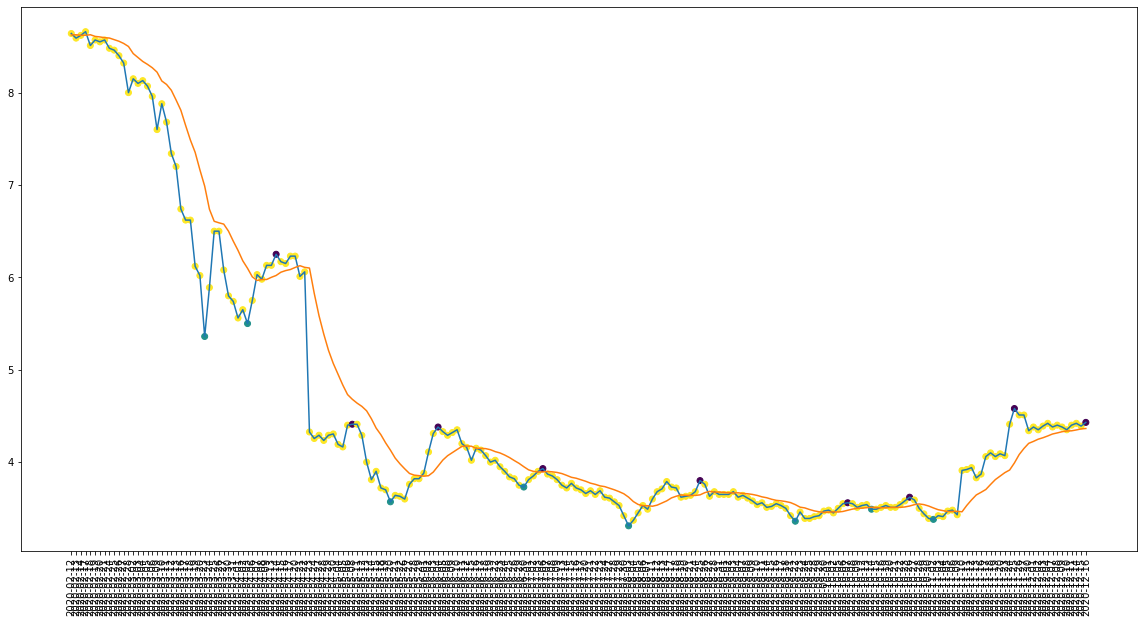

In [225]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [226]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 19
actual holds but predicted sell: 11
actual predicted holds: 168
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 84.84848484848484%
actual buys: 8
actual sells: 9
actual holds: 198


In [227]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 60.0%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 84.69945355191257%


In [228]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.319999694824219
Shares owned at the moment: 1198
Cash capital at the moment: $5.230126605987607


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9562.874126605988


Share price: $6.739999771118164
Shares owned at the moment: 1414
Cash capital at the moment: $6.305961134910831


Stop Loss Activated!

Share price: $6.119999885559082
Shares owned at the moment: 0
Cash capital at the moment: $8636.188179760456


Share price: $5.559999942779541
Shares owned at the moment: 1549
Cash capital at the moment: $0.0640586386925861


Stop Loss Activated!

Share price: $4.326051235198976
Shares owned at the moment: 0
Cash capital at the moment: $6682.689525212768


Share price: $4.255593776702882
Shares owned at the moment: 1566
Cash capital at the moment: $0.10295629668326


Stop Loss Activated!

Share price: $4.0
Shares owned at the moment: 0
Cash capital at the moment: $6246.876956296683


Share price: $3.5999999046325684
Shares 

In [229]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


### OCBC Bank

In [230]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


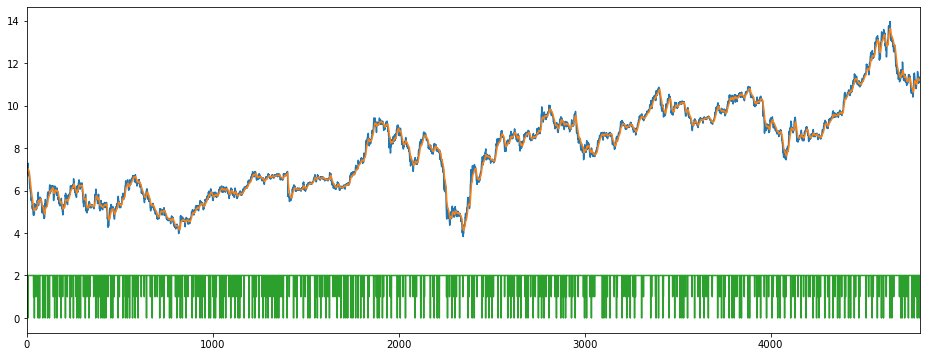

In [231]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [232]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0

In [233]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [234]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [235]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [236]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [237]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4779, 64, 64, 1)

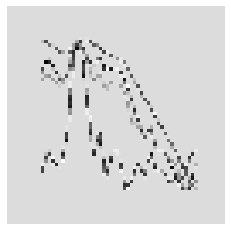

In [238]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [239]:
X = X/255

In [240]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [241]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [242]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [439]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [440]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.240530303030303, 1: 7.915113871635611, 2: 0.36555746796710653}
Epoch 1/200
30/30 [==============================] - 2s 82ms/step - loss: 0.2345 - accuracy: 0.4538 - mse: 1.5666 - weighted_accuracy: 0.3611 - weighted_mse: 1.5990 - val_loss: 0.2141 - val_accuracy: 0.0439 - val_mse: 1.0033 - val_weighted_accuracy: 0.0439 - val_weighted_mse: 1.0033
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2109 - accuracy: 0.2446 - mse: 1.2058 - weighted_accuracy: 0.3206 - weighted_mse: 1.2051 - val_loss: 0.1989 - val_accuracy: 0.0492 - val_mse: 0.9848 - val_weighted_accuracy: 0.0492 - val_weighted_mse: 0.9848
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2096 - accuracy: 0.2231 - mse: 1.1774 - weighted_accuracy: 0.3208 - weighted_mse: 1.1672 - val_loss: 0.2031 - val_accuracy: 0.0481 - val_mse: 1.0909 - val_weighted_accuracy: 0.0481 - val_weighted_mse: 1.0909
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2063 -

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1712 - accuracy: 0.2187 - mse: 1.3170 - weighted_accuracy: 0.5600 - weighted_mse: 1.2632 - val_loss: 0.1962 - val_accuracy: 0.1726 - val_mse: 1.1408 - val_weighted_accuracy: 0.1726 - val_weighted_mse: 1.1408
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1693 - accuracy: 0.2134 - mse: 1.3396 - weighted_accuracy: 0.5473 - weighted_mse: 1.2973 - val_loss: 0.1947 - val_accuracy: 0.2207 - val_mse: 1.0566 - val_weighted_accuracy: 0.2207 - val_weighted_mse: 1.0566
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1675 - accuracy: 0.2192 - mse: 1.3153 - weighted_accuracy: 0.5814 - weighted_mse: 1.2926 - val_loss: 0.1946 - val_accuracy: 0.2008 - val_mse: 1.1722 - val_weighted_accuracy: 0.2008 - val_weighted_mse: 1.1722
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1675 - accuracy: 0.2281 - mse: 1.3547 - weighted_accuracy: 0.5611 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1459 - accuracy: 0.2679 - mse: 1.5379 - weighted_accuracy: 0.6416 - weighted_mse: 1.5676 - val_loss: 0.1869 - val_accuracy: 0.3347 - val_mse: 1.2924 - val_weighted_accuracy: 0.3347 - val_weighted_mse: 1.2924
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1464 - accuracy: 0.3029 - mse: 1.5508 - weighted_accuracy: 0.6456 - weighted_mse: 1.5821 - val_loss: 0.1800 - val_accuracy: 0.4006 - val_mse: 1.3334 - val_weighted_accuracy: 0.4006 - val_weighted_mse: 1.3334
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1437 - accuracy: 0.3338 - mse: 1.5587 - weighted_accuracy: 0.6637 - weighted_mse: 1.6140 - val_loss: 0.1827 - val_accuracy: 0.3672 - val_mse: 1.2984 - val_weighted_accuracy: 0.3672 - val_weighted_mse: 1.2984
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1448 - accuracy: 0.3346 - mse: 1.5537 - weighted_accuracy: 0.6430 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1197 - accuracy: 0.4687 - mse: 1.8666 - weighted_accuracy: 0.7415 - weighted_mse: 2.1295 - val_loss: 0.1678 - val_accuracy: 0.5188 - val_mse: 1.4518 - val_weighted_accuracy: 0.5188 - val_weighted_mse: 1.4518
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1209 - accuracy: 0.4721 - mse: 1.8472 - weighted_accuracy: 0.7467 - weighted_mse: 2.0798 - val_loss: 0.1555 - val_accuracy: 0.6088 - val_mse: 1.5282 - val_weighted_accuracy: 0.6088 - val_weighted_mse: 1.5282
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1197 - accuracy: 0.4918 - mse: 1.8856 - weighted_accuracy: 0.7563 - weighted_mse: 2.1223 - val_loss: 0.1541 - val_accuracy: 0.6182 - val_mse: 1.5063 - val_weighted_accuracy: 0.6182 - val_weighted_mse: 1.5063
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1207 - accuracy: 0.5124 - mse: 1.9210 - weighted_accuracy: 0.7576 - 

Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1019 - accuracy: 0.6257 - mse: 2.1815 - weighted_accuracy: 0.8057 - weighted_mse: 2.8295 - val_loss: 0.1375 - val_accuracy: 0.7249 - val_mse: 1.7969 - val_weighted_accuracy: 0.7249 - val_weighted_mse: 1.7969
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1018 - accuracy: 0.6139 - mse: 2.1953 - weighted_accuracy: 0.8069 - weighted_mse: 2.7909 - val_loss: 0.1437 - val_accuracy: 0.6705 - val_mse: 1.8351 - val_weighted_accuracy: 0.6705 - val_weighted_mse: 1.8351
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0961 - accuracy: 0.6461 - mse: 2.2974 - weighted_accuracy: 0.8250 - weighted_mse: 3.0396 - val_loss: 0.1433 - val_accuracy: 0.6726 - val_mse: 1.8026 - val_weighted_accuracy: 0.6726 - val_weighted_mse: 1.8026
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0955 - accuracy: 0.6432 - mse: 2.3516 - weighted_accuracy: 0.8162 -

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0833 - accuracy: 0.7243 - mse: 2.8792 - weighted_accuracy: 0.8520 - weighted_mse: 4.2903 - val_loss: 0.1102 - val_accuracy: 0.8222 - val_mse: 2.1343 - val_weighted_accuracy: 0.8222 - val_weighted_mse: 2.1343
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0845 - accuracy: 0.7253 - mse: 2.6362 - weighted_accuracy: 0.8529 - weighted_mse: 3.8375 - val_loss: 0.1239 - val_accuracy: 0.7730 - val_mse: 1.9801 - val_weighted_accuracy: 0.7730 - val_weighted_mse: 1.9801
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0824 - accuracy: 0.7301 - mse: 2.8200 - weighted_accuracy: 0.8546 - weighted_mse: 4.1267 - val_loss: 0.1228 - val_accuracy: 0.7699 - val_mse: 2.2092 - val_weighted_accuracy: 0.7699 - val_weighted_mse: 2.2092
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0844 - accuracy: 0.7306 - mse: 2.8715 - weighted_accuracy: 0.8341 - 

In [441]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10702252388000488
Test accuracy: 0.8284518718719482


In [442]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.450782   -1.2408668   0.10429195]
 [-1.1725571  -2.062788    0.20641613]
 [-1.6763296  -1.1335613  -0.01262271]
 ...
 [-2.0204802  -1.2562538   0.17691034]
 [-2.303962   -1.0746647   0.0248266 ]
 [-1.6605581  -1.4510174   0.243507  ]]


Counter({2: 874, 0: 30, 1: 52})

In [443]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 872, 0: 44, 1: 40})

In [444]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 956
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 39
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 44
actual holds but predicted buy: 51
actual holds but predicted sell: 30
actual predicted holds: 791
Percentage buys correct: 2.5%
Percentage sells correct: 0.0%
Percentage holds correct: 90.71100917431193%
actual buys: 40
actual sells: 44
actual holds: 872


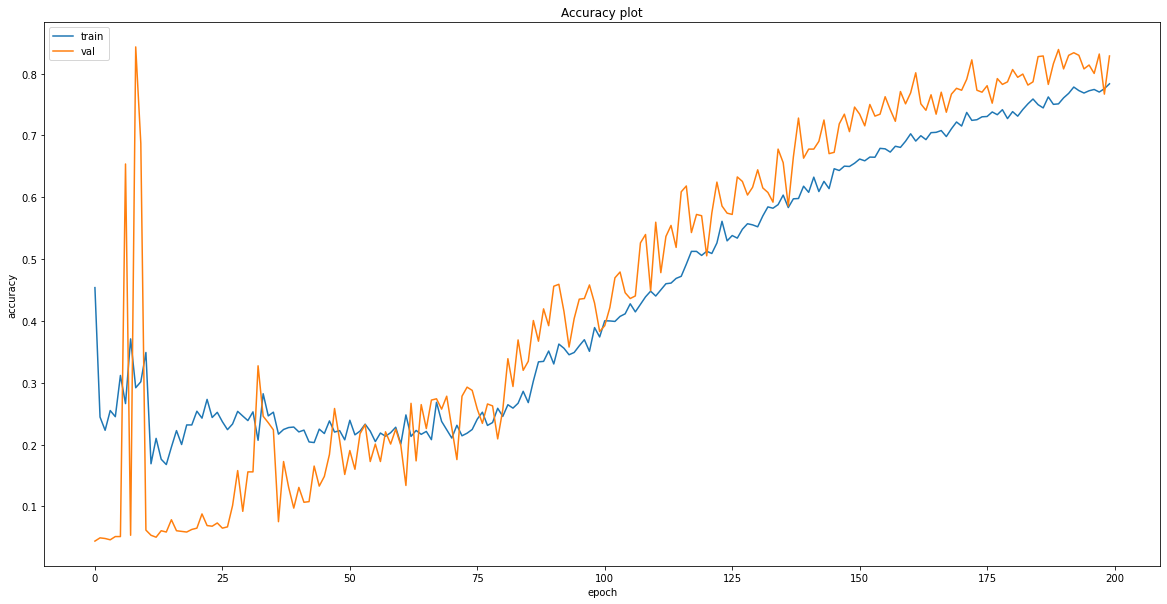

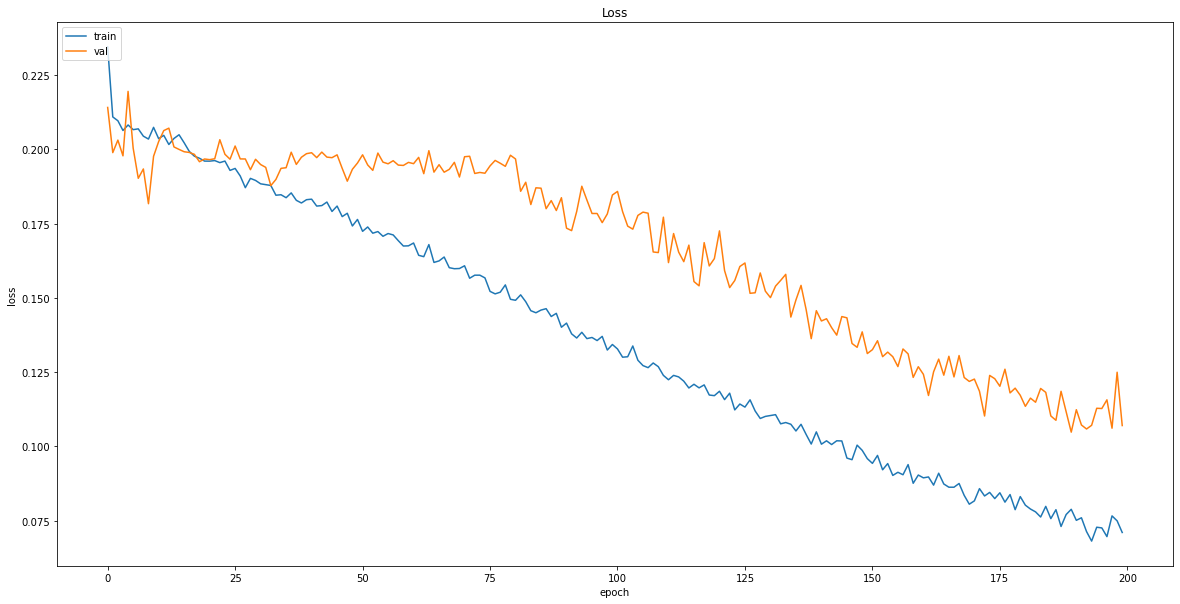

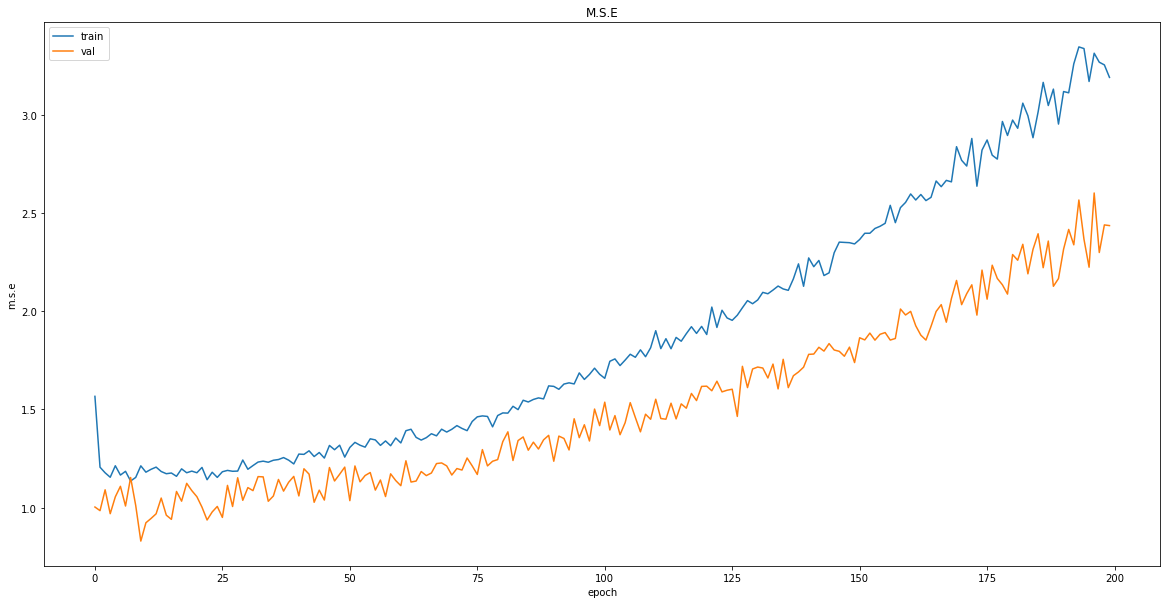

In [445]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [446]:
# Save model
model.save("models/{}".format('OCBC_image_cnn_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/OCBC_image_cnn_buy_hold_sell_25.model\assets


### Test Performance

#### Non-Recession

In [447]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


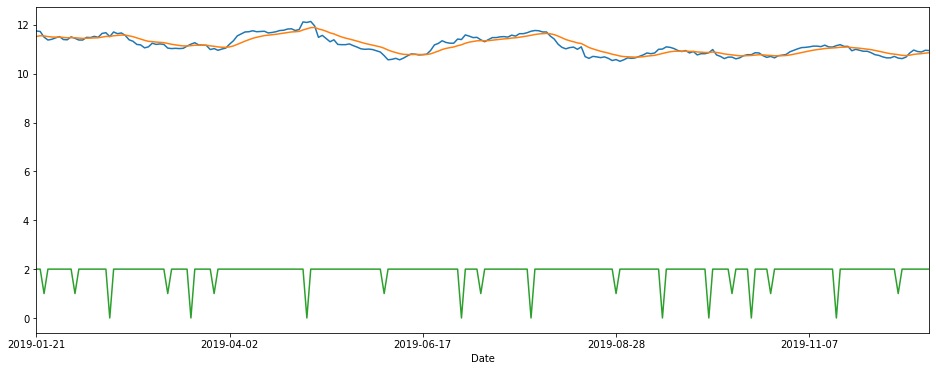

In [448]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [449]:
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])

In [450]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1
        
# willr_data = np.array(willr_data)
# price_data = np.array(price_data)
# ema_data = np.array(ema_data)
# obv_data = np.array(obv_data)

In [451]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [452]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [453]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [454]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [455]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1049 - accuracy: 0.8165 - mean_squared_error: 2.5084 - weighted_accuracy: 0.8165 - weighted_mean_squared_error: 2.5084
Test loss: 0.10491671413183212
Test accuracy: 0.8165137767791748


In [456]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 195, 0: 11, 1: 12})

In [457]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [458]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-458-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-458-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-458-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        11.53  11.457507 -67.857228  17615658.0     2.0   
2019-02-12        11.49  11.468659 -43.902530  20832858.0     2.0   
2019-02-13        11.65  11.471942 -42.424356  17325458.0     2.0   
2019-02-14        11.68  11.499336 -10.256417  22091358.0     2.0   
2019-02-15        11.52  11.527130  -5.714153  24228358.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

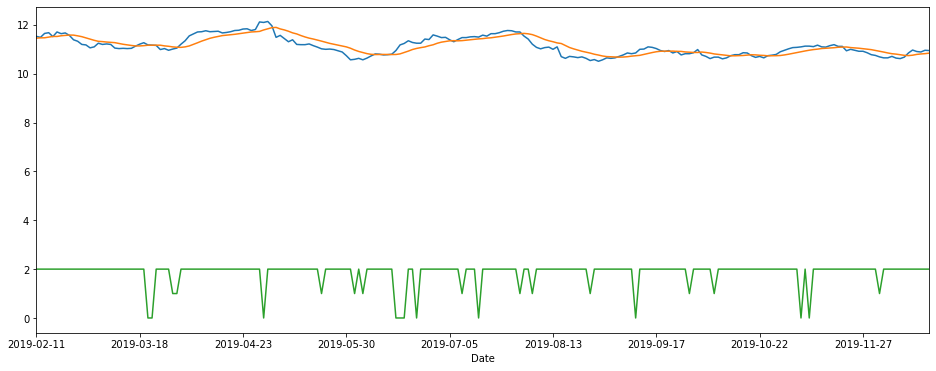

In [459]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

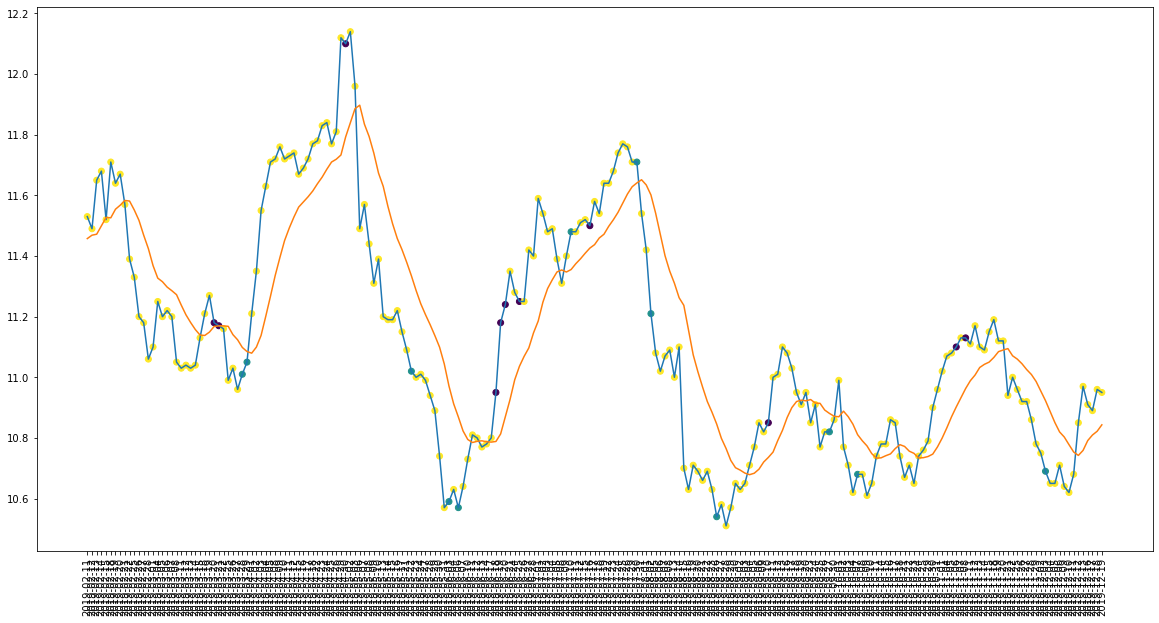

In [460]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

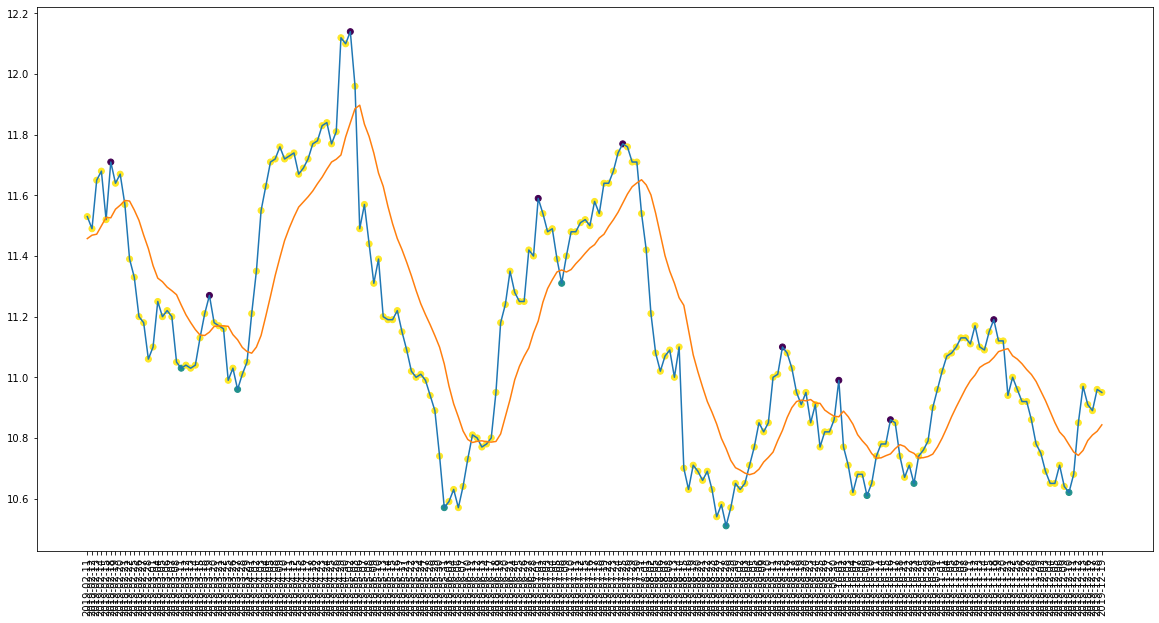

In [461]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [462]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 12
actual holds but predicted sell: 11
actual predicted holds: 178
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 88.55721393034825%
actual buys: 8
actual sells: 9
actual holds: 201


In [463]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 85.05154639175258%


In [464]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.010000228881836
Shares owned at the moment: 905
Cash capital at the moment: $8.548654792308298


Price increase from previously bought: 9.598695593732831%
Share price: $12.100000381469727
Shares owned at the moment: 0
Cash capital at the moment: $10928.935124073028


Share price: $11.020000457763672
Shares owned at the moment: 989
Cash capital at the moment: $0.18302509975364956


Stop Loss Activated!

Share price: $10.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10425.16496661091


Share price: $10.59000015258789
Shares owned at the moment: 981
Cash capital at the moment: $7.805644010544711


Price increase from previously bought: 5.281770165913113%
Share price: $11.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $10945.225097564697


Share price: $11.479999542236328
Shares owned at the moment: 950
Cash capital at the moment: $9.234033636092136


Stop Loss Activated!

Share price: $11.079999923706056
Shares owned a

In [465]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


#### Recession

In [466]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


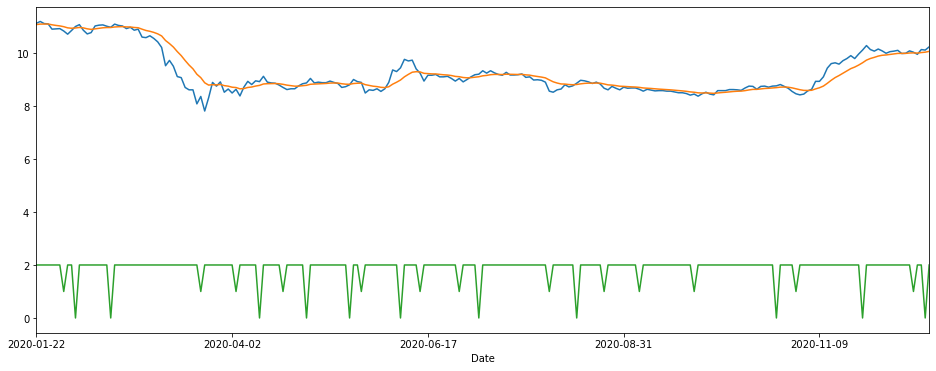

In [467]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [468]:
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-12-09        10.71  10.802927 -75.438564  46900142.0     2.0
2019-12-10        10.64  10.777861 -87.272614  42802742.0     1.0
2019-12-11        10.62  10.753575 -90.196045  37577242.0     2.0
2019-12-12        10.68  10.742256 -78.431263  41151442.0     2.0
2019-12-13        10.85  10.758832 -45.097929  47717842.0     2.0

In [469]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [470]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [471]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [472]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [473]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1138 - accuracy: 0.8326 - mean_squared_error: 2.5069 - weighted_accuracy: 0.8326 - weighted_mean_squared_error: 2.5069
Test loss: 0.11381421983242035
Test accuracy: 0.8325581550598145


In [474]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 197, 1: 11, 0: 7})

In [475]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [476]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-476-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-476-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-476-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-12        11.02  10.890637 -80.357049  13333200.0     2.0   
2020-02-13        11.05  10.910539 -32.075322  21593100.0     2.0   
2020-02-14        11.06  10.931995 -15.217324  25962500.0     2.0   
2020-02-17        11.01  10.951688 -13.043361  29610200.0     2.0   
2020-02-18        10.97  10.960659 -23.912967  27996300.0     2.0   

            predictions  actual  
Date                             
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            2       2  
2020-02-18            2       2

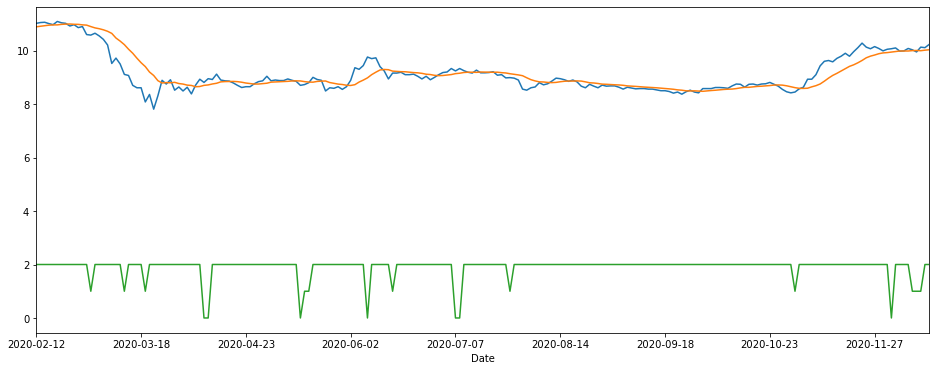

In [477]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

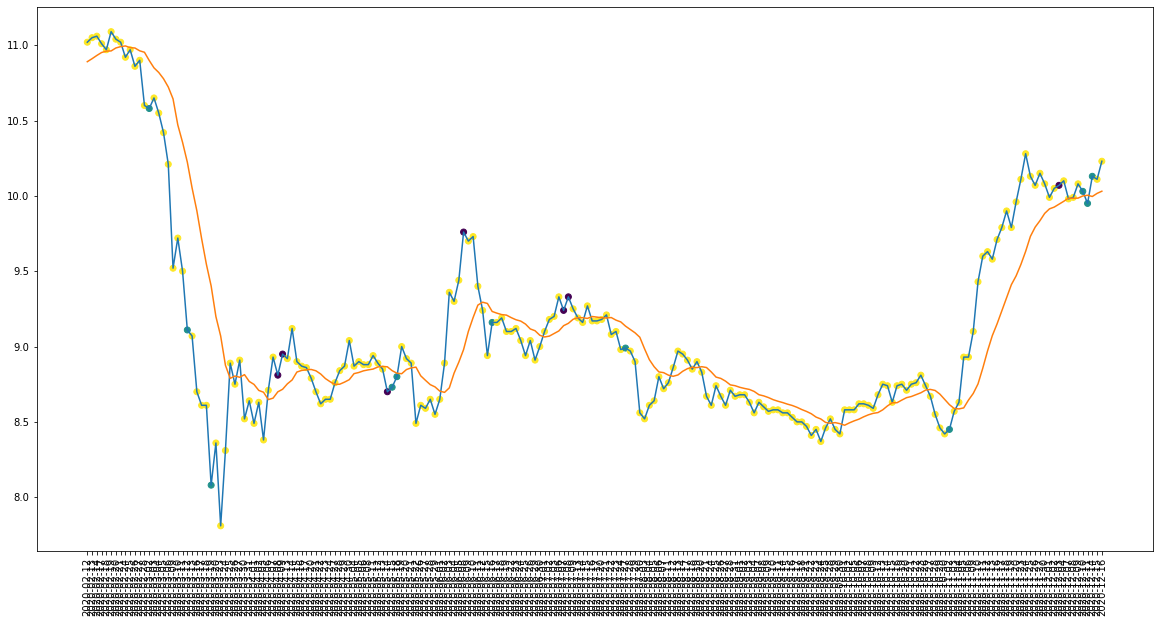

In [478]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

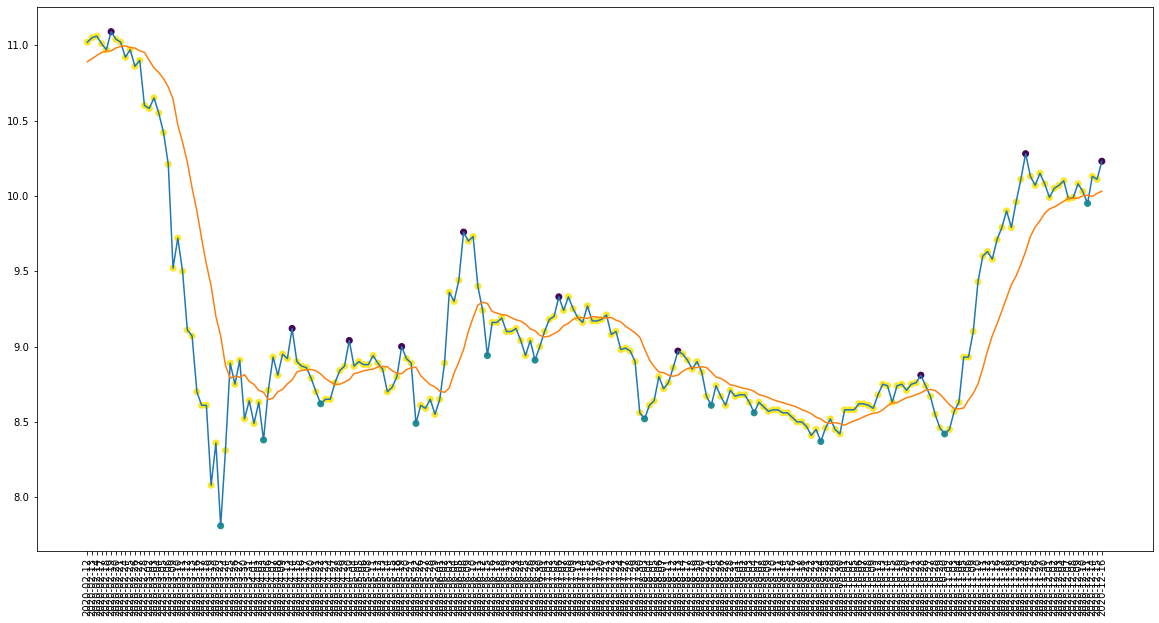

In [479]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [480]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 10
actual holds but predicted sell: 6
actual predicted holds: 177
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 10.0%
Percentage holds correct: 91.70984455958549%
actual buys: 12
actual sells: 10
actual holds: 193


In [481]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 72.72727272727273%
Percentage sells correct: 57.142857142857146%
Percentage holds correct: 86.73469387755102%


In [482]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.579999923706056
Shares owned at the moment: 942
Cash capital at the moment: $6.232582066533723


Stop Loss Activated!

Share price: $10.210000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9597.603612902161


Share price: $9.109999656677246
Shares owned at the moment: 1050
Cash capital at the moment: $5.798849382397748


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $9115.67739966154


Share price: $8.079999923706055
Shares owned at the moment: 1125
Cash capital at the moment: $0.6799857282621815


Stop Loss Activated!

Share price: $7.809999942779541
Shares owned at the moment: 0
Cash capital at the moment: $8762.767734032272


Share price: $8.729999542236326
Shares owned at the moment: 1001
Cash capital at the moment: $0.006686013817670755


Stop Loss Activated!

Share price: $8.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8475.125610033154


Share pr

In [483]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


## CNOOC Limited

In [484]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


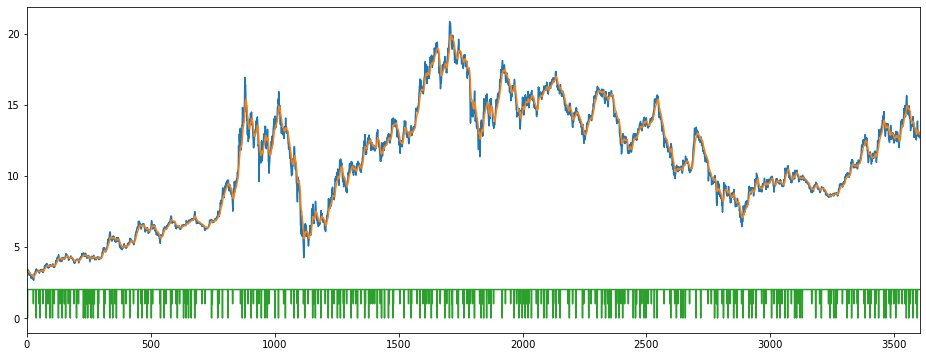

In [485]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [486]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0

In [487]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [488]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [489]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [490]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(3580, 64, 64, 1)

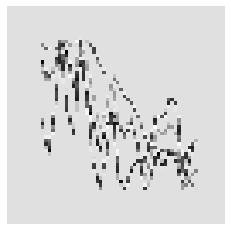

In [491]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [492]:
X = X/255

In [493]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [494]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [495]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [634]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [635]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.232323232323233, 1: 7.343589743589743, 2: 0.3668972585190879}
Epoch 1/200
23/23 [==============================] - 3s 122ms/step - loss: 0.2592 - accuracy: 0.4860 - mse: 1.7227 - weighted_accuracy: 0.3258 - weighted_mse: 1.7895 - val_loss: 0.1872 - val_accuracy: 0.8492 - val_mse: 0.8309 - val_weighted_accuracy: 0.8492 - val_weighted_mse: 0.8309
Epoch 2/200
23/23 [==============================] - 0s 9ms/step - loss: 0.2073 - accuracy: 0.4162 - mse: 1.2066 - weighted_accuracy: 0.3442 - weighted_mse: 1.2276 - val_loss: 0.1981 - val_accuracy: 0.0447 - val_mse: 1.0124 - val_weighted_accuracy: 0.0447 - val_weighted_mse: 1.0124
Epoch 3/200
23/23 [==============================] - 0s 9ms/step - loss: 0.2037 - accuracy: 0.3534 - mse: 1.1598 - weighted_accuracy: 0.3282 - weighted_mse: 1.1826 - val_loss: 0.2008 - val_accuracy: 0.0768 - val_mse: 0.9077 - val_weighted_accuracy: 0.0768 - val_weighted_mse: 0.9077
Epoch 4/200
23/23 [==============================] - 0s 9ms/step - loss: 0.2042 -

Epoch 57/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1912 - accuracy: 0.2133 - mse: 1.2238 - weighted_accuracy: 0.4261 - weighted_mse: 1.2148 - val_loss: 0.1996 - val_accuracy: 0.0698 - val_mse: 0.9066 - val_weighted_accuracy: 0.0698 - val_weighted_mse: 0.9066
Epoch 58/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1871 - accuracy: 0.2186 - mse: 1.1846 - weighted_accuracy: 0.4912 - weighted_mse: 1.1943 - val_loss: 0.1979 - val_accuracy: 0.0684 - val_mse: 1.0098 - val_weighted_accuracy: 0.0684 - val_weighted_mse: 1.0098
Epoch 59/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1873 - accuracy: 0.1878 - mse: 1.2127 - weighted_accuracy: 0.4654 - weighted_mse: 1.2189 - val_loss: 0.2001 - val_accuracy: 0.0670 - val_mse: 1.0606 - val_weighted_accuracy: 0.0670 - val_weighted_mse: 1.0606
Epoch 60/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1869 - accuracy: 0.1868 - mse: 1.2881 - weighted_accuracy: 0.4935 - weig

Epoch 86/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1684 - accuracy: 0.1885 - mse: 1.3516 - weighted_accuracy: 0.5622 - weighted_mse: 1.3132 - val_loss: 0.1974 - val_accuracy: 0.1327 - val_mse: 1.0736 - val_weighted_accuracy: 0.1327 - val_weighted_mse: 1.0736
Epoch 87/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1660 - accuracy: 0.1735 - mse: 1.2857 - weighted_accuracy: 0.5713 - weighted_mse: 1.2471 - val_loss: 0.1980 - val_accuracy: 0.1313 - val_mse: 1.2042 - val_weighted_accuracy: 0.1313 - val_weighted_mse: 1.2042
Epoch 88/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1644 - accuracy: 0.1788 - mse: 1.3978 - weighted_accuracy: 0.5876 - weighted_mse: 1.3639 - val_loss: 0.1968 - val_accuracy: 0.1411 - val_mse: 1.1535 - val_weighted_accuracy: 0.1411 - val_weighted_mse: 1.1535
Epoch 89/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1665 - accuracy: 0.2203 - mse: 1.3686 - weighted_accuracy: 0.5761 - weig

Epoch 115/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1463 - accuracy: 0.2479 - mse: 1.5790 - weighted_accuracy: 0.6638 - weighted_mse: 1.6049 - val_loss: 0.1972 - val_accuracy: 0.2430 - val_mse: 1.2758 - val_weighted_accuracy: 0.2430 - val_weighted_mse: 1.2758
Epoch 116/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1424 - accuracy: 0.2689 - mse: 1.5001 - weighted_accuracy: 0.6907 - weighted_mse: 1.5810 - val_loss: 0.1986 - val_accuracy: 0.2514 - val_mse: 1.3809 - val_weighted_accuracy: 0.2514 - val_weighted_mse: 1.3809
Epoch 117/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1410 - accuracy: 0.2640 - mse: 1.5767 - weighted_accuracy: 0.6914 - weighted_mse: 1.6651 - val_loss: 0.1962 - val_accuracy: 0.2682 - val_mse: 1.3918 - val_weighted_accuracy: 0.2682 - val_weighted_mse: 1.3918
Epoch 118/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1446 - accuracy: 0.2507 - mse: 1.5781 - weighted_accuracy: 0.6624 -

Epoch 144/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1260 - accuracy: 0.4089 - mse: 1.7785 - weighted_accuracy: 0.7349 - weighted_mse: 2.1424 - val_loss: 0.1712 - val_accuracy: 0.4902 - val_mse: 1.5601 - val_weighted_accuracy: 0.4902 - val_weighted_mse: 1.5601
Epoch 145/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1260 - accuracy: 0.4092 - mse: 1.8338 - weighted_accuracy: 0.7351 - weighted_mse: 2.1435 - val_loss: 0.1778 - val_accuracy: 0.4455 - val_mse: 1.5190 - val_weighted_accuracy: 0.4455 - val_weighted_mse: 1.5190
Epoch 146/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1227 - accuracy: 0.4120 - mse: 1.8407 - weighted_accuracy: 0.7506 - weighted_mse: 2.2418 - val_loss: 0.1786 - val_accuracy: 0.4330 - val_mse: 1.4133 - val_weighted_accuracy: 0.4330 - val_weighted_mse: 1.4133
Epoch 147/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1249 - accuracy: 0.4134 - mse: 1.7915 - weighted_accuracy: 0.7340 -

Epoch 173/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1067 - accuracy: 0.5716 - mse: 2.1038 - weighted_accuracy: 0.7970 - weighted_mse: 2.9233 - val_loss: 0.1551 - val_accuracy: 0.6466 - val_mse: 1.7057 - val_weighted_accuracy: 0.6466 - val_weighted_mse: 1.7057
Epoch 174/200
23/23 [==============================] - 0s 9ms/step - loss: 0.1037 - accuracy: 0.5765 - mse: 2.2063 - weighted_accuracy: 0.8085 - weighted_mse: 3.2277 - val_loss: 0.1573 - val_accuracy: 0.6229 - val_mse: 1.7141 - val_weighted_accuracy: 0.6229 - val_weighted_mse: 1.7141
Epoch 175/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1032 - accuracy: 0.5768 - mse: 2.1645 - weighted_accuracy: 0.8085 - weighted_mse: 2.9947 - val_loss: 0.1537 - val_accuracy: 0.6620 - val_mse: 1.7460 - val_weighted_accuracy: 0.6620 - val_weighted_mse: 1.7460
Epoch 176/200
23/23 [==============================] - 0s 10ms/step - loss: 0.1028 - accuracy: 0.5925 - mse: 2.3036 - weighted_accuracy: 0.8239 

In [636]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12946023046970367
Test accuracy: 0.7723463773727417


In [637]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.2382956  -0.59228075 -0.3937095 ]
 [-1.9972457  -0.71551627 -0.3700572 ]
 [-2.1290307  -0.9348154  -0.215978  ]
 ...
 [-0.7241153  -1.918903   -0.27296165]
 [-1.9191216  -0.5757943  -0.2541193 ]
 [-1.6675404  -1.3479874  -0.20718585]]


Counter({2: 592, 0: 72, 1: 52})

In [638]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 651, 1: 32, 0: 33})

In [639]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 716
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 24
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 28
actual holds but predicted buy: 44
actual holds but predicted sell: 67
actual predicted holds: 540
Percentage buys correct: 25.0%
Percentage sells correct: 15.151515151515152%
Percentage holds correct: 82.94930875576037%
actual buys: 32
actual sells: 33
actual holds: 651


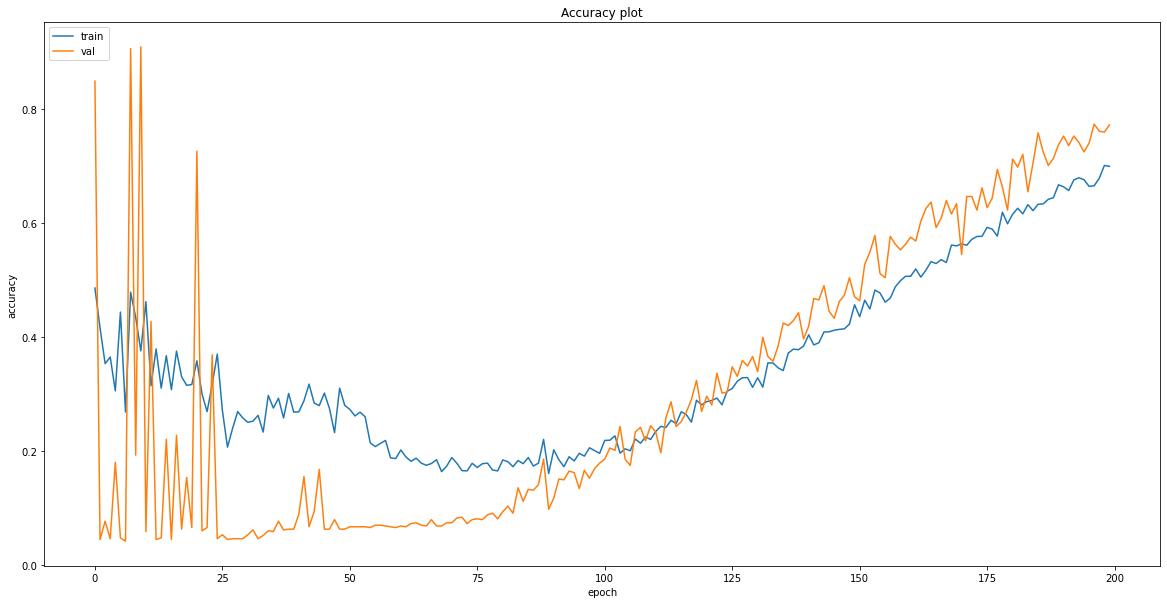

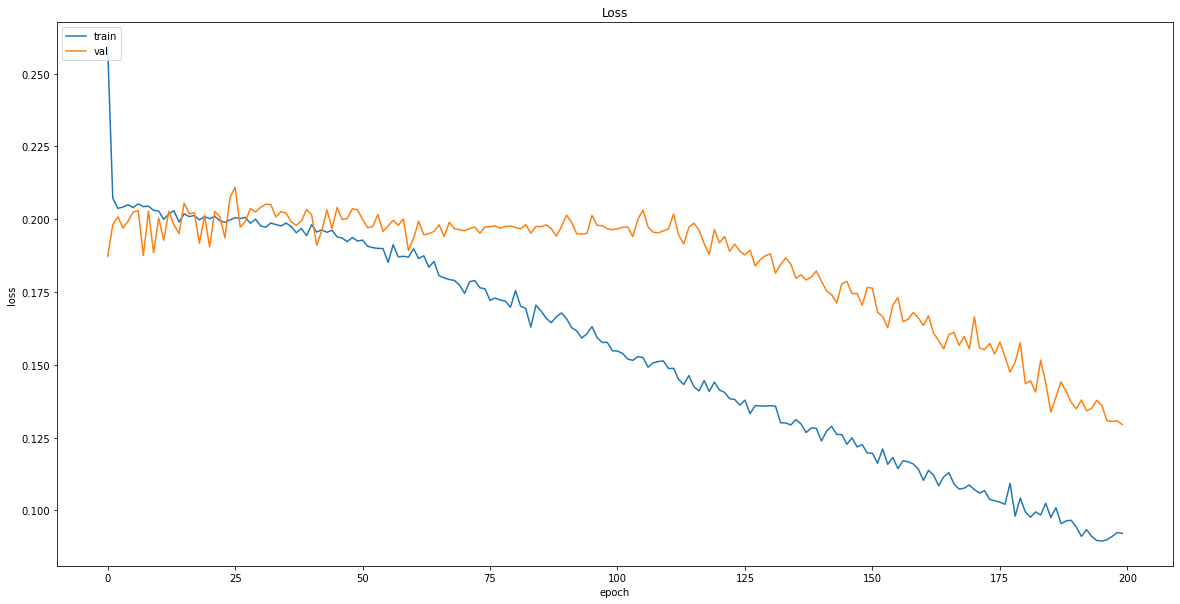

In [640]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [641]:
# Save model
model.save("models/{}".format('cnooc_image_cnn_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/cnooc_image_cnn_buy_hold_sell_25.model\assets


### Test Performance

#### Non-Recession

In [642]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2018-12-05        13.84  13.206983 -13.953473  9.687209e+09     2.0
2018-12-06        13.32  13.224370 -44.186053  9.629185e+09     2.0
2018-12-07        13.06  13.199082 -59.302288  9.569866e+09     2.0
2018-12-10        12.78  13.134608 -75.581395  9.417195e+09     2.0
2018-12-11        12.82  13.086207 -73.255816  9.502415e+09     2.0

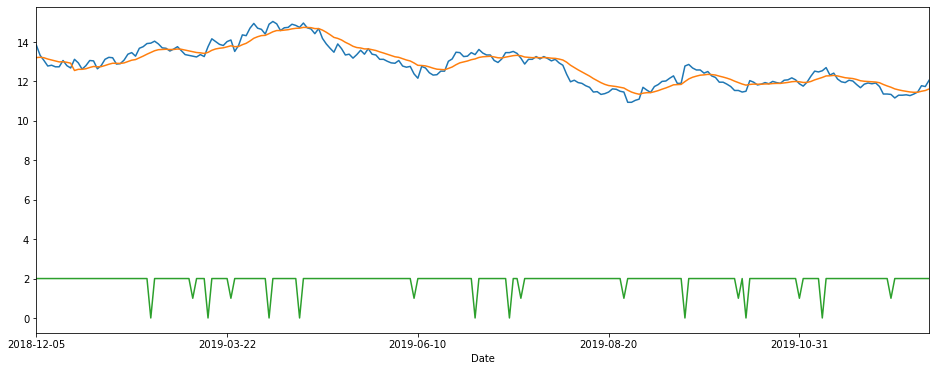

In [643]:
#%matplotlib notebook
df2['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df2['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df2['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [644]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [645]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [646]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [647]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [648]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1277 - accuracy: 0.8057 - mean_squared_error: 2.1602 - weighted_accuracy: 0.8057 - weighted_mean_squared_error: 2.1602
Test loss: 0.12774613499641418
Test accuracy: 0.8056871891021729


In [649]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 180, 0: 16, 1: 15})

In [650]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [651]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-651-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-651-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-651-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-14        13.46  13.005887  -9.090899  594167146.0     2.0   
2019-02-15        13.28  13.075751  -2.222168  636062191.0     2.0   
2019-02-18        13.68  13.107174 -22.222210  601994876.0     2.0   
2019-02-19        13.76  13.195301 -15.384598  654106730.0     2.0   
2019-02-20        13.92  13.282178  -9.230759  687559434.0     2.0   

            predictions  actual  
Date                             
2019-02-14            2       2  
2019-02-15            2       2  
2019-02-18            2       2  
2019-02-19            2       2  
2019-02-20            0       2

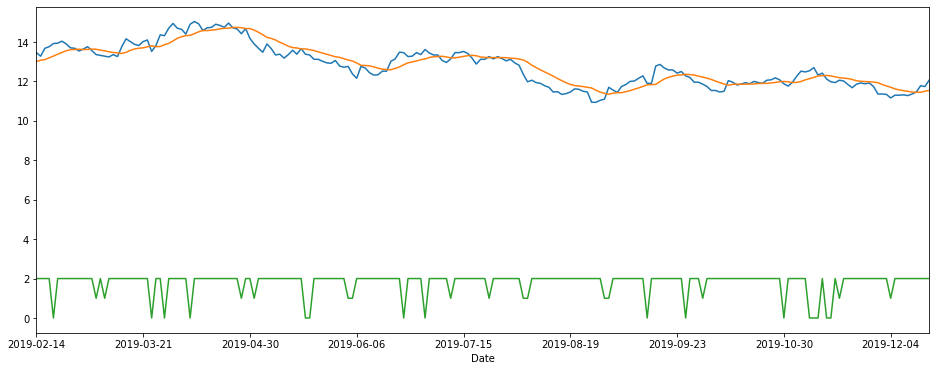

In [652]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

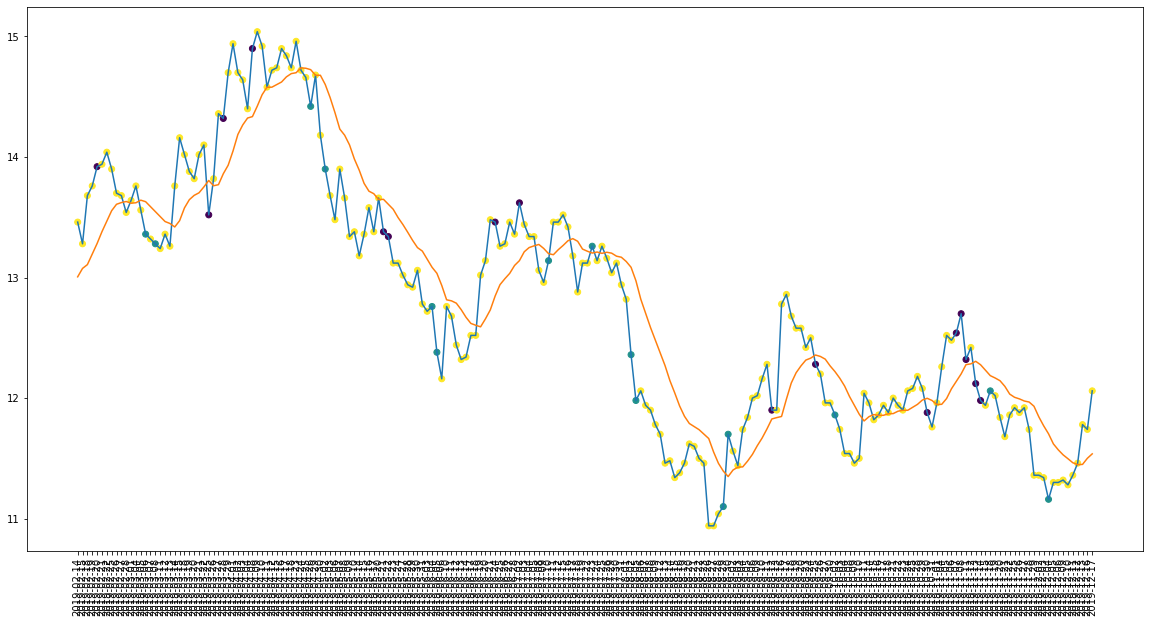

In [653]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

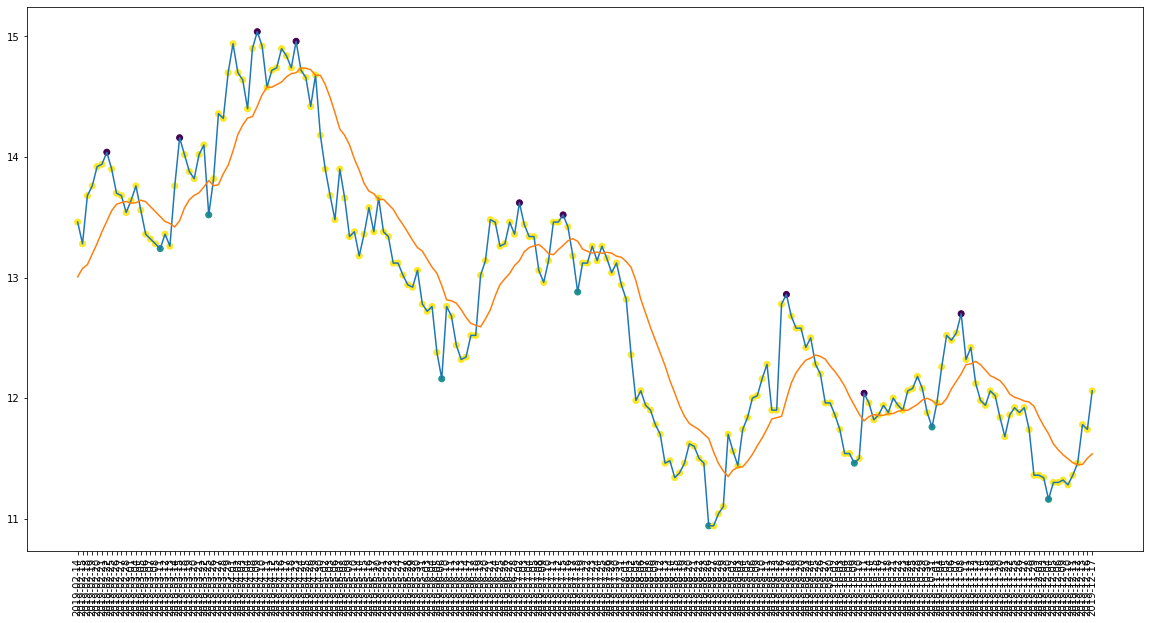

In [654]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [655]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 211
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 14
actual holds but predicted sell: 13
actual predicted holds: 167
Percentage buys correct: 12.5%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 86.08247422680412%
actual buys: 8
actual sells: 9
actual holds: 194


In [656]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 60.0%
Percentage sells correct: 43.75%
Percentage holds correct: 82.68156424581005%


In [657]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.359999656677244
Shares owned at the moment: 746
Cash capital at the moment: $6.0322168231032265


Price increase from previously bought: 6.891677100674309%
Share price: $14.31999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10659.37450978804


Share price: $14.420000076293945
Shares owned at the moment: 737
Cash capital at the moment: $2.6087184047737537


Stop Loss Activated!

Share price: $13.899999618530273
Shares owned at the moment: 0
Cash capital at the moment: $10218.736613034729


Share price: $13.899999618530273
Shares owned at the moment: 733
Cash capital at the moment: $2.0179684209851985


Stop Loss Activated!

Share price: $13.479999542236328
Shares owned at the moment: 0
Cash capital at the moment: $9855.68532380295


Share price: $12.760000228881836
Shares owned at the moment: 770
Cash capital at the moment: $3.465847079280138


Stop Loss Activated!

Share price: $12.380000114440918
Shares owned at the moment: 0
Cash capital at the

In [658]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


### Recession

In [659]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-12-05        11.16  11.619972 -96.000004 -309527686.0     2.0
2019-12-06        11.30  11.570745 -81.249969 -265649189.0     2.0
2019-12-09        11.30  11.529092 -81.249969 -265649189.0     2.0
2019-12-10        11.32  11.496924 -79.166687 -219481840.0     2.0
2019-12-11        11.28  11.463551 -83.333350 -262942881.0     2.0

In [660]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [661]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [662]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [663]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [664]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1362 - accuracy: 0.7324 - mean_squared_error: 2.2412 - weighted_accuracy: 0.7324 - weighted_mean_squared_error: 2.2412
Test loss: 0.13624130189418793
Test accuracy: 0.7323943376541138


In [665]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 13, 2: 170, 1: 30})

In [666]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [667]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-667-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-667-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-667-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2020-02-13        12.34  12.385912 -50.526328  113135355.0     2.0   
2020-02-14        12.34  12.378849 -50.588221   60757697.0     2.0   
2020-02-17        12.26  12.372872 -46.153851   60757697.0     2.0   
2020-02-18        12.00  12.355507 -38.709648    5146960.0     2.0   
2020-02-19        12.08  12.300814 -59.677412  -52626865.0     2.0   

            predictions  actual  
Date                             
2020-02-13            0       2  
2020-02-14            2       2  
2020-02-17            1       2  
2020-02-18            2       2  
2020-02-19            2       2

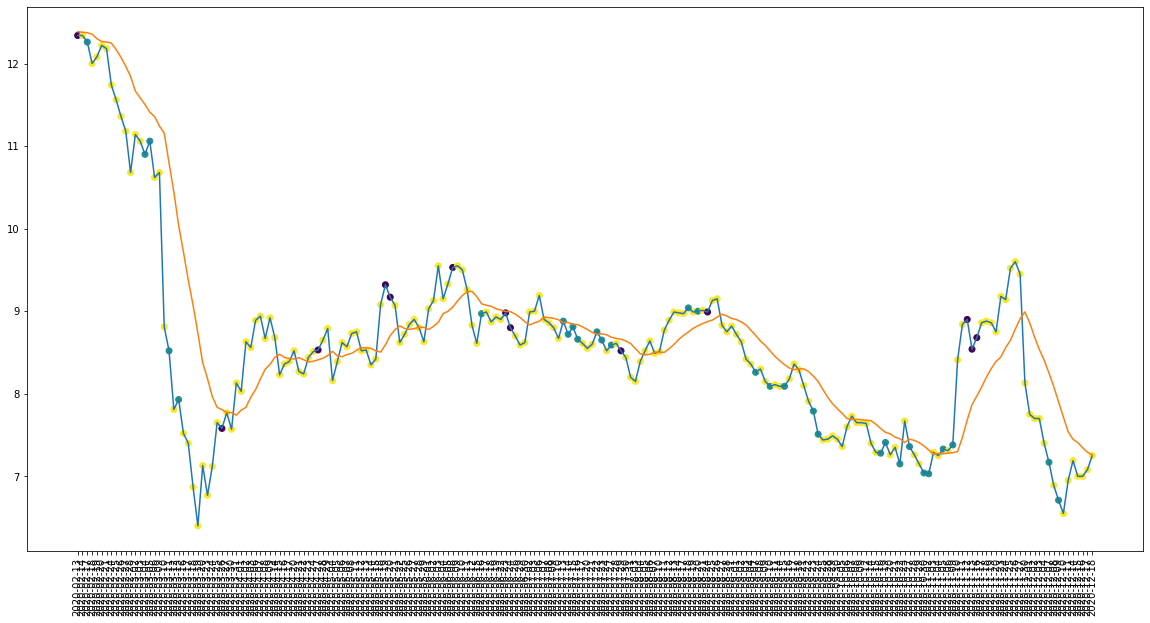

In [668]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

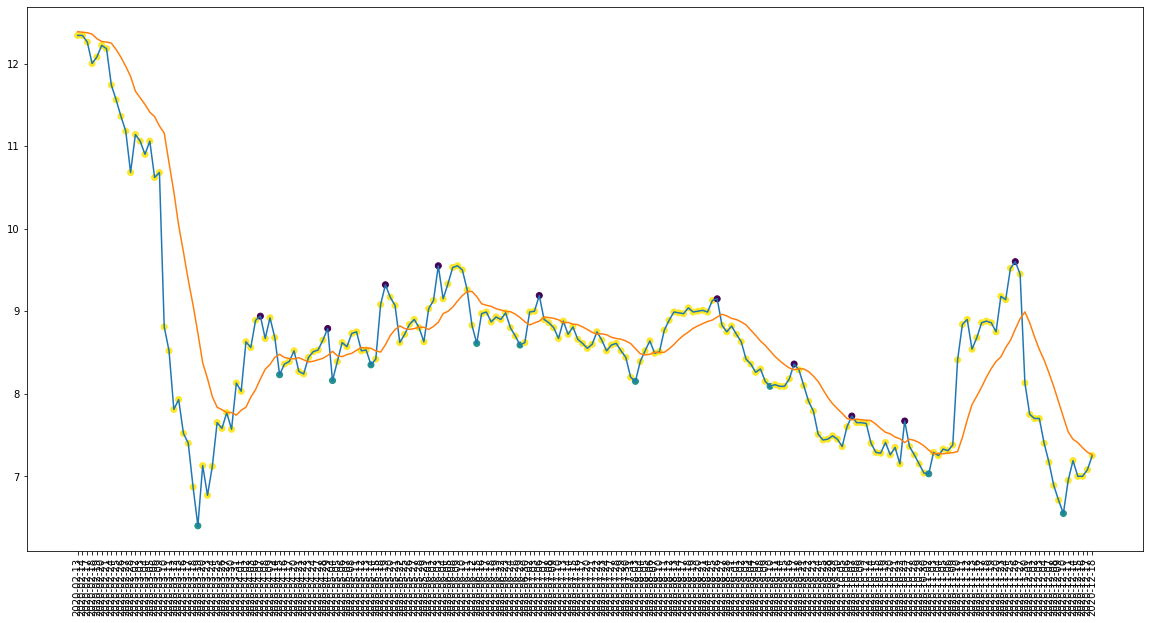

In [669]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [670]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 28
actual holds but predicted sell: 12
actual predicted holds: 153
Percentage buys correct: 20.0%
Percentage sells correct: 10.0%
Percentage holds correct: 79.27461139896373%
actual buys: 10
actual sells: 10
actual holds: 193


In [671]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 30.0%
Percentage sells correct: 61.53846153846154%
Percentage holds correct: 84.02366863905326%


In [672]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $12.260000228881836
Shares owned at the moment: 813
Cash capital at the moment: $5.209518407344149


Stop Loss Activated!

Share price: $11.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9523.581627838133


Share price: $10.899999618530273
Shares owned at the moment: 871
Cash capital at the moment: $3.573736011980145


Stop Loss Activated!

Share price: $8.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7655.981947993038


Share price: $8.520000457763674
Shares owned at the moment: 896
Cash capital at the moment: $1.0682567088570067


Stop Loss Activated!

Share price: $7.809999942779541
Shares owned at the moment: 0
Cash capital at the moment: $6979.584365580316


Share price: $7.929999828338622
Shares owned at the moment: 877
Cash capital at the moment: $5.849339041348685


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $6582.752962359901


Share price: $

In [673]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


## JP Morgan

In [674]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


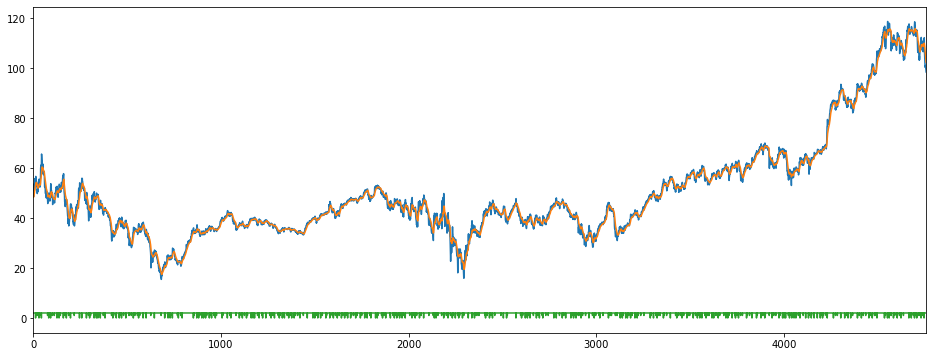

In [675]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [676]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0

In [677]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1

In [678]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [679]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [680]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4735, 64, 64, 1)

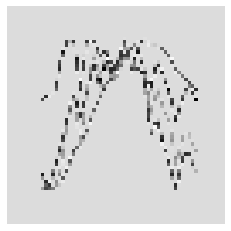

In [681]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [682]:
X = X/255

In [683]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [684]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [685]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [724]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [725]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.699186991869919, 1: 7.427450980392157, 2: 0.36556649295502797}
Epoch 1/200
30/30 [==============================] - 2s 65ms/step - loss: 0.2401 - accuracy: 0.3382 - mse: 1.6637 - weighted_accuracy: 0.3157 - weighted_mse: 1.6897 - val_loss: 0.2088 - val_accuracy: 0.0433 - val_mse: 0.9512 - val_weighted_accuracy: 0.0433 - val_weighted_mse: 0.9512
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2044 - accuracy: 0.3501 - mse: 1.1828 - weighted_accuracy: 0.3353 - weighted_mse: 1.1870 - val_loss: 0.2036 - val_accuracy: 0.0454 - val_mse: 1.0421 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 1.0421
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2043 - accuracy: 0.3596 - mse: 1.1770 - weighted_accuracy: 0.3379 - weighted_mse: 1.1857 - val_loss: 0.2068 - val_accuracy: 0.0454 - val_mse: 1.0005 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 1.0005
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2030 -

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1783 - accuracy: 0.3178 - mse: 1.2703 - weighted_accuracy: 0.5470 - weighted_mse: 1.2442 - val_loss: 0.1976 - val_accuracy: 0.1140 - val_mse: 1.0698 - val_weighted_accuracy: 0.1140 - val_weighted_mse: 1.0698
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1791 - accuracy: 0.3134 - mse: 1.2284 - weighted_accuracy: 0.5299 - weighted_mse: 1.2137 - val_loss: 0.1948 - val_accuracy: 0.2862 - val_mse: 0.9579 - val_weighted_accuracy: 0.2862 - val_weighted_mse: 0.9579
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1778 - accuracy: 0.3065 - mse: 1.2427 - weighted_accuracy: 0.5235 - weighted_mse: 1.2195 - val_loss: 0.1839 - val_accuracy: 0.3770 - val_mse: 1.1477 - val_weighted_accuracy: 0.3770 - val_weighted_mse: 1.1477
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1763 - accuracy: 0.3487 - mse: 1.2518 - weighted_accuracy: 0.5484 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1480 - accuracy: 0.3788 - mse: 1.4790 - weighted_accuracy: 0.6621 - weighted_mse: 1.4728 - val_loss: 0.1851 - val_accuracy: 0.3601 - val_mse: 1.2537 - val_weighted_accuracy: 0.3601 - val_weighted_mse: 1.2537
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1422 - accuracy: 0.3775 - mse: 1.5035 - weighted_accuracy: 0.6713 - weighted_mse: 1.5063 - val_loss: 0.1810 - val_accuracy: 0.3865 - val_mse: 1.3070 - val_weighted_accuracy: 0.3865 - val_weighted_mse: 1.3070
Epoch 88/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1435 - accuracy: 0.3933 - mse: 1.5102 - weighted_accuracy: 0.6731 - weighted_mse: 1.5012 - val_loss: 0.1916 - val_accuracy: 0.3073 - val_mse: 1.3069 - val_weighted_accuracy: 0.3073 - val_weighted_mse: 1.3069
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1406 - accuracy: 0.3897 - mse: 1.4928 - weighted_accuracy: 0.6887 - we

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1209 - accuracy: 0.5364 - mse: 1.7104 - weighted_accuracy: 0.7416 - weighted_mse: 1.8734 - val_loss: 0.1561 - val_accuracy: 0.6220 - val_mse: 1.4330 - val_weighted_accuracy: 0.6220 - val_weighted_mse: 1.4330
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1202 - accuracy: 0.5568 - mse: 1.6971 - weighted_accuracy: 0.7610 - weighted_mse: 1.8707 - val_loss: 0.1564 - val_accuracy: 0.6030 - val_mse: 1.5332 - val_weighted_accuracy: 0.6030 - val_weighted_mse: 1.5332
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1250 - accuracy: 0.5367 - mse: 1.7414 - weighted_accuracy: 0.7343 - weighted_mse: 1.8748 - val_loss: 0.1606 - val_accuracy: 0.5797 - val_mse: 1.3887 - val_weighted_accuracy: 0.5797 - val_weighted_mse: 1.3887
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1188 - accuracy: 0.5531 - mse: 1.7836 - weighted_accuracy: 0.7446 -

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1037 - accuracy: 0.6565 - mse: 2.0775 - weighted_accuracy: 0.7745 - weighted_mse: 2.5027 - val_loss: 0.1419 - val_accuracy: 0.7043 - val_mse: 1.6805 - val_weighted_accuracy: 0.7043 - val_weighted_mse: 1.6805
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1025 - accuracy: 0.6518 - mse: 2.0580 - weighted_accuracy: 0.7839 - weighted_mse: 2.4993 - val_loss: 0.1464 - val_accuracy: 0.6800 - val_mse: 1.5971 - val_weighted_accuracy: 0.6800 - val_weighted_mse: 1.5971
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0986 - accuracy: 0.6684 - mse: 2.0817 - weighted_accuracy: 0.7920 - weighted_mse: 2.5196 - val_loss: 0.1436 - val_accuracy: 0.6917 - val_mse: 1.7542 - val_weighted_accuracy: 0.6917 - val_weighted_mse: 1.7542
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0947 - accuracy: 0.6536 - mse: 2.0904 - weighted_accuracy: 0.8019 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0828 - accuracy: 0.7489 - mse: 2.3644 - weighted_accuracy: 0.8258 - weighted_mse: 3.0541 - val_loss: 0.1261 - val_accuracy: 0.7561 - val_mse: 1.8440 - val_weighted_accuracy: 0.7561 - val_weighted_mse: 1.8440
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0830 - accuracy: 0.7452 - mse: 2.3647 - weighted_accuracy: 0.8205 - weighted_mse: 3.1124 - val_loss: 0.1213 - val_accuracy: 0.7782 - val_mse: 1.9093 - val_weighted_accuracy: 0.7782 - val_weighted_mse: 1.9093
Epoch 175/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0812 - accuracy: 0.7284 - mse: 2.4539 - weighted_accuracy: 0.8123 - weighted_mse: 3.2153 - val_loss: 0.1193 - val_accuracy: 0.8046 - val_mse: 1.8050 - val_weighted_accuracy: 0.8046 - val_weighted_mse: 1.8050
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0747 - accuracy: 0.7521 - mse: 2.4903 - weighted_accuracy: 0.8557 -

In [726]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11618264019489288
Test accuracy: 0.7961985468864441


In [727]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.6210831  -1.8941165   0.544485  ]
 [-1.1644363  -1.5699587   0.35412264]
 [-1.3376456  -2.1691139   0.554549  ]
 ...
 [-1.6683239  -0.83064526 -0.09219602]
 [-0.8519479  -1.7375324   0.10405087]
 [-1.3094257  -1.1338096   0.13246553]]


Counter({2: 820, 0: 48, 1: 79})

In [728]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 41, 1: 43})

In [729]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 947
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 36
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 38
actual holds but predicted buy: 72
actual holds but predicted sell: 45
actual predicted holds: 746
Percentage buys correct: 13.953488372093023%
Percentage sells correct: 4.878048780487805%
Percentage holds correct: 86.44264194669756%
actual buys: 43
actual sells: 41
actual holds: 863


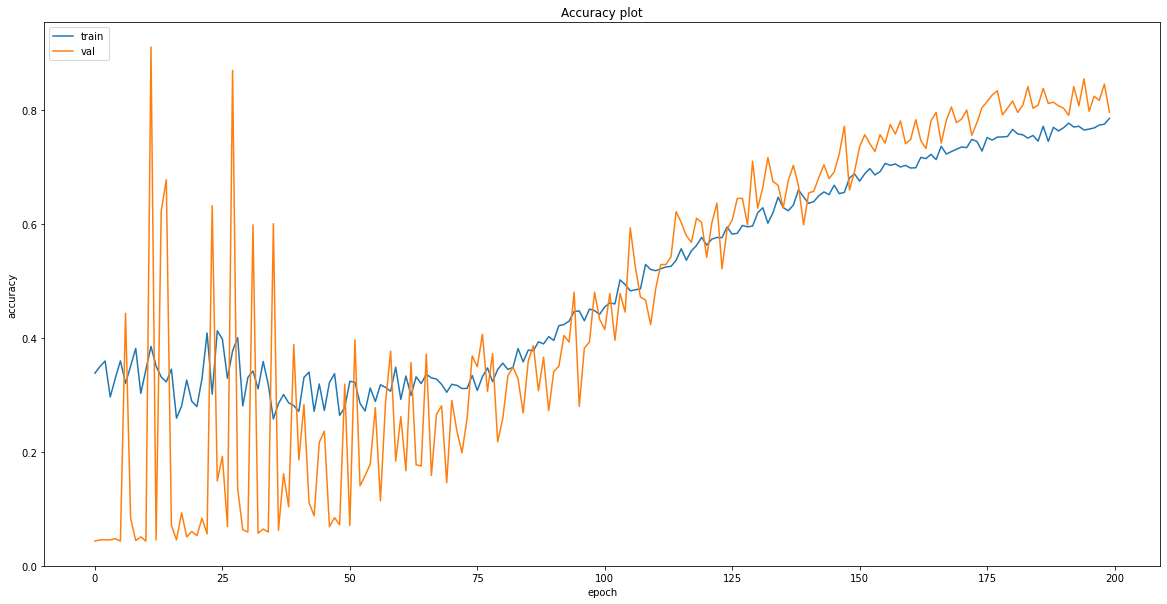

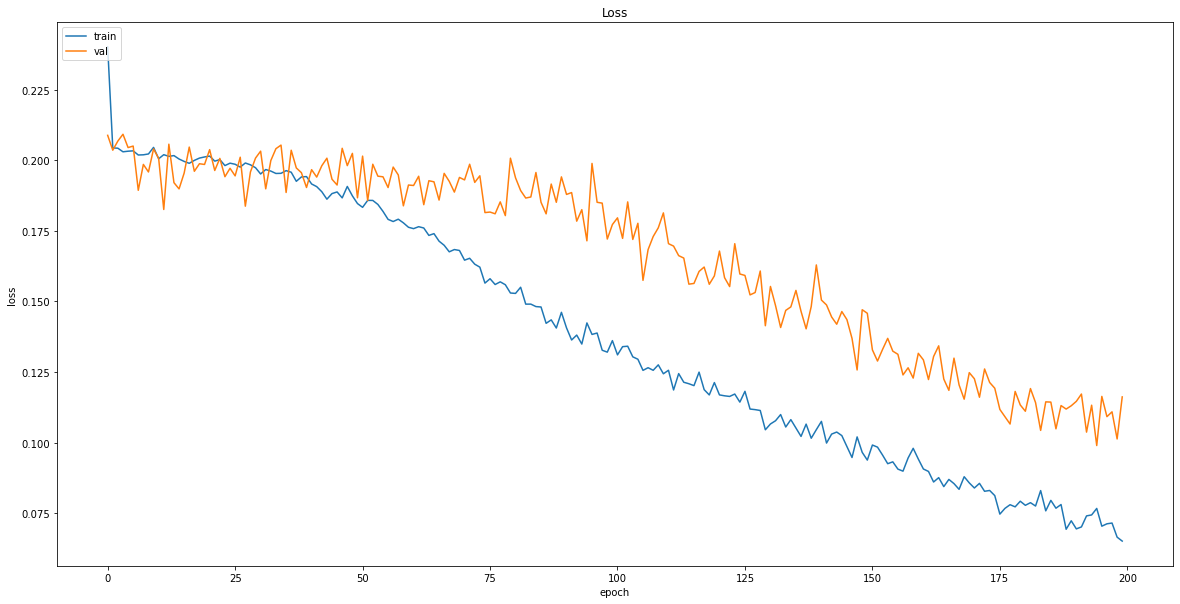

In [730]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [731]:
# Save model
model.save("models/{}".format('jpm_image_cnn_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/jpm_image_cnn_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [732]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d      EMA_12   willr_14         OBV_7  labels
Date                                                                
2018-12-06   107.230003  109.628444 -81.910265 -1.924741e+09     2.0
2018-12-07   105.190002  108.945607 -76.923030 -1.951955e+09     2.0
2018-12-10   103.290001  108.075514 -95.904060 -1.971203e+09     2.0
2018-12-11   101.360001  107.042358 -84.717107 -1.994840e+09     2.0
2018-12-12   100.370003  106.015842 -91.991154 -2.011700e+09     2.0

In [733]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [734]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [735]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [736]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [737]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1106 - accuracy: 0.8119 - mean_squared_error: 1.9014 - weighted_accuracy: 0.8119 - weighted_mean_squared_error: 1.9014
Test loss: 0.1106460765004158
Test accuracy: 0.8119266033172607


In [738]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 188, 0: 11, 1: 19})

In [739]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [740]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-740-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-740-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-740-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-11   100.879997  102.975915 -74.903417  73097300.0     1.0   
2019-02-12   102.599998  102.653466 -84.169891  62118800.0     2.0   
2019-02-13   103.089996  102.645240 -50.965236  74971100.0     2.0   
2019-02-14   102.419998  102.713664 -41.505819  85725200.0     2.0   
2019-02-15   105.550003  102.668485 -54.440145  74206700.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       1  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

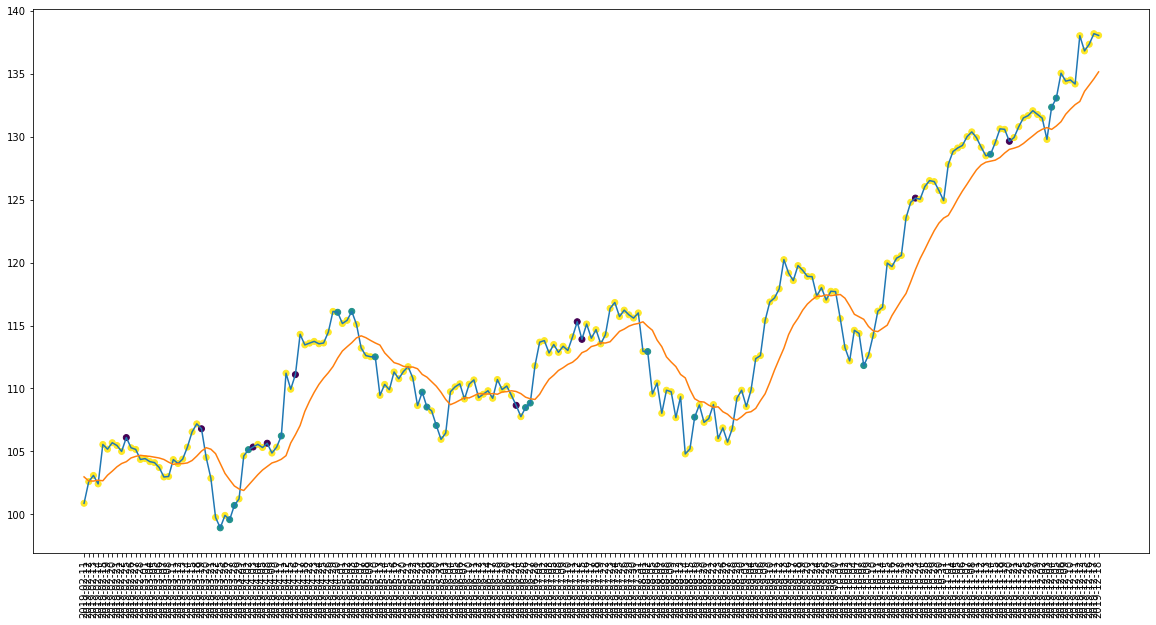

In [741]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

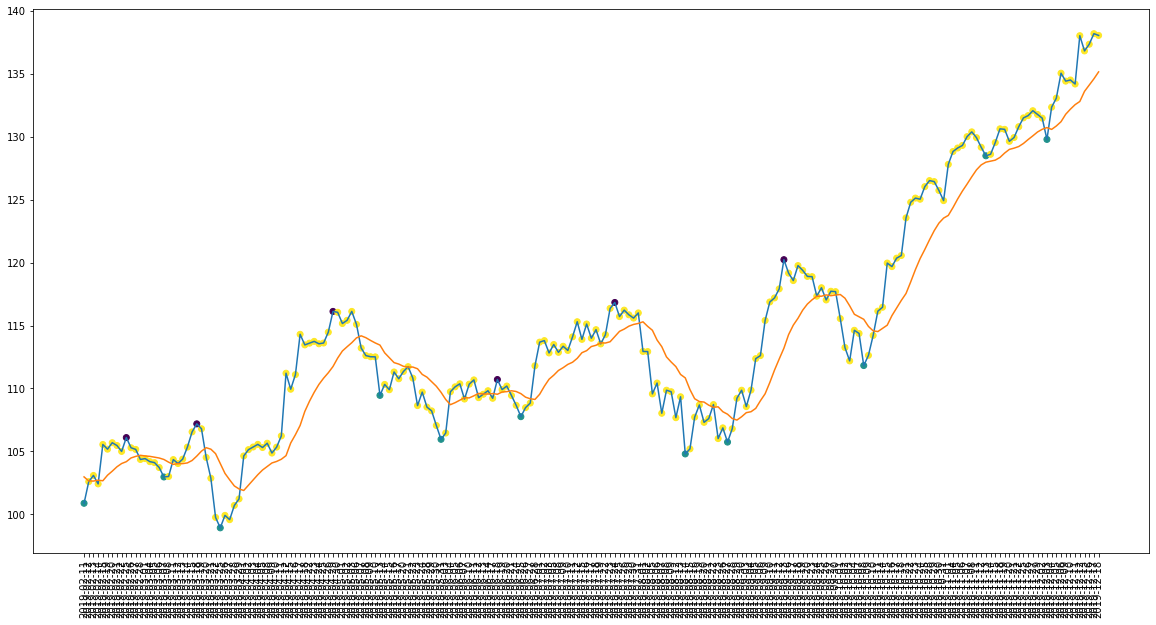

In [742]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [743]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 17
actual holds but predicted sell: 10
actual predicted holds: 174
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 86.56716417910448%
actual buys: 11
actual sells: 6
actual holds: 201


In [744]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 36.8421052631579%
Percentage sells correct: 60.0%
Percentage holds correct: 86.17021276595744%


In [745]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.93000030517578
Shares owned at the moment: 100
Cash capital at the moment: $79.79421939849817


Price increase from previously bought: 6.197392276003066%
Share price: $105.3499984741211
Shares owned at the moment: 0
Cash capital at the moment: $10585.822817230224


Share price: $106.2300033569336
Shares owned at the moment: 99
Cash capital at the moment: $40.13136647987267


Price increase from previously bought: 8.240416054575906%
Share price: $115.3000030517578
Shares owned at the moment: 0
Cash capital at the moment: $11423.441242773053


Share price: $112.93000030517578
Shares owned at the moment: 100
Cash capital at the moment: $99.3854621715509


Stop Loss Activated!

Share price: $109.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $11026.253681737895


Share price: $107.72000122070312
Shares owned at the moment: 102
Cash capital at the moment: $8.598096883768449


Price increase from previously bought: 15.834445739032788%
Share price: $

In [746]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


### recession

In [747]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-12-06   133.059998  131.187618  -5.091646  270369900.0     2.0
2019-12-09   135.039993  131.780291 -10.292145  280540500.0     2.0
2019-12-10   134.410004  132.184862 -19.054168  272042300.0     2.0
2019-12-11   134.500000  132.541037 -17.802480  279575200.0     2.0
2019-12-12   134.179993  132.793184 -22.253207  270563300.0     2.0

In [748]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [749]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [750]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [751]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [752]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1190 - accuracy: 0.7808 - mean_squared_error: 1.9858 - weighted_accuracy: 0.7808 - weighted_mean_squared_error: 1.9858
Test loss: 0.11904619634151459
Test accuracy: 0.7808219194412231


In [753]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 193, 1: 18, 0: 8})

In [754]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [755]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-755-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-755-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-755-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   138.000000  136.179383  -6.410124  26757600.0     0.0   
2020-02-12   138.000000  136.459478  -9.001177  33336200.0     2.0   
2020-02-13   137.880005  136.696481 -13.465502  33336200.0     2.0   
2020-02-14   137.460007  136.878562 -14.718062  25888700.0     2.0   
2020-02-18   135.639999  136.968015 -23.401387  19261100.0     2.0   

            predictions  actual  
Date                             
2020-02-11            2       0  
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-18            2       2

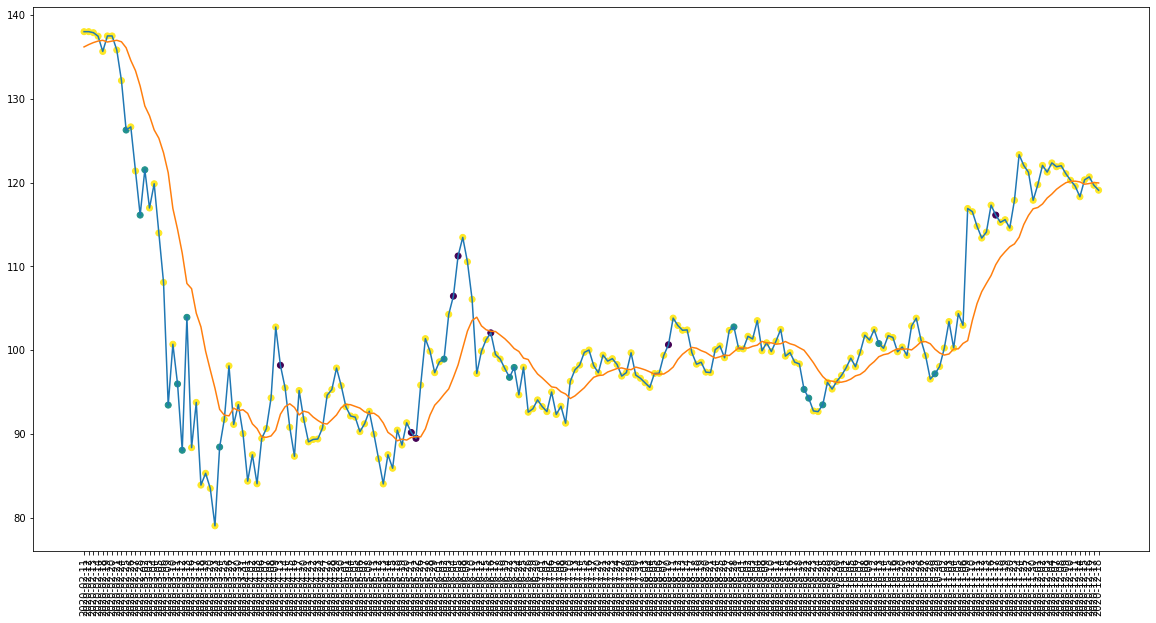

In [756]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

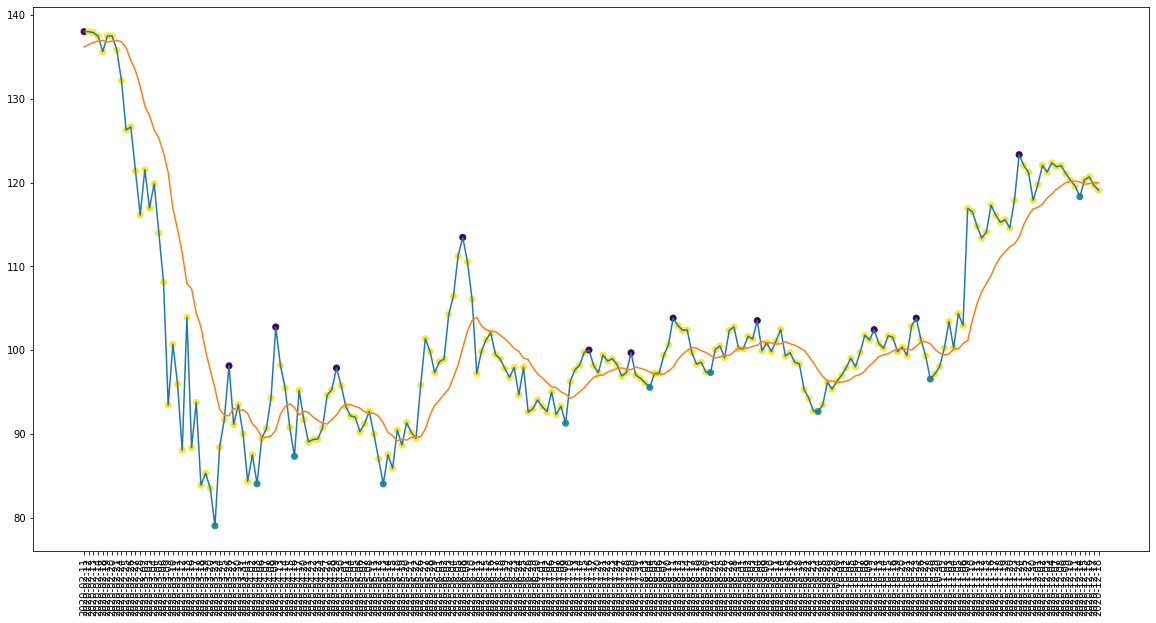

In [757]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [758]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 12
actual holds but predicted buy: 18
actual holds but predicted sell: 8
actual predicted holds: 171
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 86.80203045685279%
actual buys: 10
actual sells: 12
actual holds: 197


In [759]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 58.8235294117647%
Percentage sells correct: 62.5%
Percentage holds correct: 81.34715025906736%


In [760]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $126.26000213623048
Shares owned at the moment: 78
Cash capital at the moment: $124.6370629157991


Stop Loss Activated!

Share price: $121.37000274658205
Shares owned at the moment: 0
Cash capital at the moment: $9565.463411560057


Share price: $116.11000061035156
Shares owned at the moment: 82
Cash capital at the moment: $18.260556373594227


Stop Loss Activated!

Share price: $108.08000183105469
Shares owned at the moment: 0
Cash capital at the moment: $8856.448666107175


Share price: $93.44000244140624
Shares owned at the moment: 94
Cash capital at the moment: $48.93419598388573


Stop Loss Activated!

Share price: $88.05000305175781
Shares owned at the moment: 0
Cash capital at the moment: $8302.87355706024


Share price: $88.05000305175781
Shares owned at the moment: 94
Cash capital at the moment: $3.412344406126067


Stop Loss Activated!

Share price: $83.88999938964844
Shares owned at the moment: 0
Cash capital at the moment: $7867.386722190855


Share price: $88

In [761]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [762]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


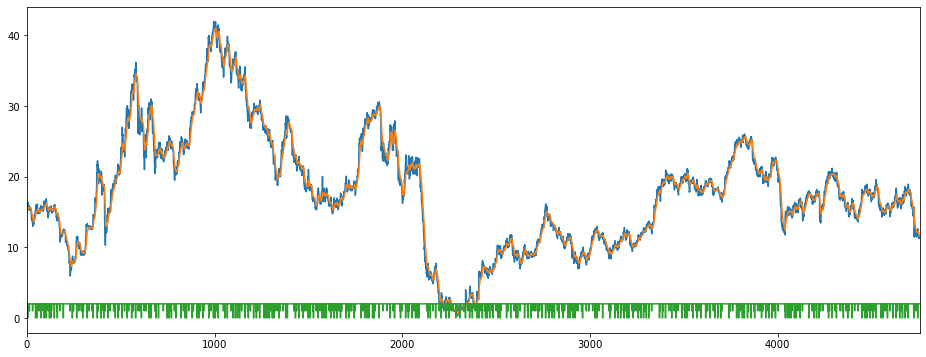

In [763]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [764]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0

In [765]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [766]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [767]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
y = np.array(y)

X.shape

(4735, 64, 64, 1)

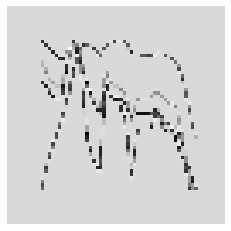

In [768]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [769]:
X = X/255

In [770]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [771]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [772]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [796]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [797]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.256704980842912, 1: 7.298651252408478, 2: 0.36694759275404437}
Epoch 1/200
30/30 [==============================] - 3s 85ms/step - loss: 0.2440 - accuracy: 0.4306 - mse: 1.6156 - weighted_accuracy: 0.3296 - weighted_mse: 1.7412 - val_loss: 0.1766 - val_accuracy: 0.9081 - val_mse: 0.9313 - val_weighted_accuracy: 0.9081 - val_weighted_mse: 0.9313
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2075 - accuracy: 0.4968 - mse: 1.1400 - weighted_accuracy: 0.3229 - weighted_mse: 1.1701 - val_loss: 0.1862 - val_accuracy: 0.9081 - val_mse: 0.8705 - val_weighted_accuracy: 0.9081 - val_weighted_mse: 0.8705
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2063 - accuracy: 0.5145 - mse: 1.1284 - weighted_accuracy: 0.3513 - weighted_mse: 1.1642 - val_loss: 0.1969 - val_accuracy: 0.9007 - val_mse: 0.7585 - val_weighted_accuracy: 0.9007 - val_weighted_mse: 0.7585
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2100 

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1923 - accuracy: 0.3989 - mse: 1.2011 - weighted_accuracy: 0.4053 - weighted_mse: 1.2023 - val_loss: 0.1884 - val_accuracy: 0.4667 - val_mse: 1.0191 - val_weighted_accuracy: 0.4667 - val_weighted_mse: 1.0191
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1913 - accuracy: 0.4079 - mse: 1.1878 - weighted_accuracy: 0.4598 - weighted_mse: 1.1659 - val_loss: 0.1881 - val_accuracy: 0.4498 - val_mse: 1.0395 - val_weighted_accuracy: 0.4498 - val_weighted_mse: 1.0395
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1903 - accuracy: 0.4403 - mse: 1.2068 - weighted_accuracy: 0.4716 - weighted_mse: 1.2014 - val_loss: 0.1936 - val_accuracy: 0.2122 - val_mse: 1.0716 - val_weighted_accuracy: 0.2122 - val_weighted_mse: 1.0716
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1906 - accuracy: 0.4097 - mse: 1.1996 - weighted_accuracy: 0.4367 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1659 - accuracy: 0.4559 - mse: 1.2634 - weighted_accuracy: 0.6051 - weighted_mse: 1.2417 - val_loss: 0.1848 - val_accuracy: 0.3654 - val_mse: 1.1003 - val_weighted_accuracy: 0.3654 - val_weighted_mse: 1.1003
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1672 - accuracy: 0.4359 - mse: 1.2593 - weighted_accuracy: 0.5904 - weighted_mse: 1.2204 - val_loss: 0.1706 - val_accuracy: 0.5713 - val_mse: 1.1665 - val_weighted_accuracy: 0.5713 - val_weighted_mse: 1.1665
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1646 - accuracy: 0.4422 - mse: 1.2792 - weighted_accuracy: 0.6128 - weighted_mse: 1.2439 - val_loss: 0.1827 - val_accuracy: 0.3780 - val_mse: 1.2226 - val_weighted_accuracy: 0.3780 - val_weighted_mse: 1.2226
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1643 - accuracy: 0.4285 - mse: 1.2696 - weighted_accuracy: 0.6169 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1368 - accuracy: 0.5293 - mse: 1.4271 - weighted_accuracy: 0.7013 - weighted_mse: 1.4335 - val_loss: 0.1581 - val_accuracy: 0.6272 - val_mse: 1.2979 - val_weighted_accuracy: 0.6272 - val_weighted_mse: 1.2979
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1364 - accuracy: 0.5385 - mse: 1.3832 - weighted_accuracy: 0.7084 - weighted_mse: 1.4119 - val_loss: 0.1698 - val_accuracy: 0.5248 - val_mse: 1.2761 - val_weighted_accuracy: 0.5248 - val_weighted_mse: 1.2761
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1334 - accuracy: 0.5565 - mse: 1.4332 - weighted_accuracy: 0.7077 - weighted_mse: 1.4739 - val_loss: 0.1720 - val_accuracy: 0.5026 - val_mse: 1.2704 - val_weighted_accuracy: 0.5026 - val_weighted_mse: 1.2704
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1355 - accuracy: 0.5512 - mse: 1.4136 - weighted_accuracy: 0.7294 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1138 - accuracy: 0.6381 - mse: 1.6627 - weighted_accuracy: 0.7576 - weighted_mse: 1.8071 - val_loss: 0.1463 - val_accuracy: 0.6917 - val_mse: 1.4388 - val_weighted_accuracy: 0.6917 - val_weighted_mse: 1.4388
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1128 - accuracy: 0.6407 - mse: 1.6845 - weighted_accuracy: 0.7622 - weighted_mse: 1.8662 - val_loss: 0.1449 - val_accuracy: 0.7064 - val_mse: 1.4051 - val_weighted_accuracy: 0.7064 - val_weighted_mse: 1.4051
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1138 - accuracy: 0.6378 - mse: 1.6599 - weighted_accuracy: 0.7538 - weighted_mse: 1.8233 - val_loss: 0.1513 - val_accuracy: 0.6610 - val_mse: 1.4410 - val_weighted_accuracy: 0.6610 - val_weighted_mse: 1.4410
Epoch 147/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1100 - accuracy: 0.6595 - mse: 1.6943 - weighted_accuracy: 0.7709 -

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0947 - accuracy: 0.7117 - mse: 2.0294 - weighted_accuracy: 0.8009 - weighted_mse: 2.3873 - val_loss: 0.1202 - val_accuracy: 0.8057 - val_mse: 1.6789 - val_weighted_accuracy: 0.8057 - val_weighted_mse: 1.6789
Epoch 174/200
30/30 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.7101 - mse: 2.0592 - weighted_accuracy: 0.8019 - weighted_mse: 2.368 - 0s 10ms/step - loss: 0.0933 - accuracy: 0.7083 - mse: 2.0639 - weighted_accuracy: 0.8033 - weighted_mse: 2.3919 - val_loss: 0.1185 - val_accuracy: 0.8057 - val_mse: 1.7233 - val_weighted_accuracy: 0.8057 - val_weighted_mse: 1.7233
Epoch 175/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0947 - accuracy: 0.6972 - mse: 2.0425 - weighted_accuracy: 0.7902 - weighted_mse: 2.3400 - val_loss: 0.1224 - val_accuracy: 0.7983 - val_mse: 1.6609 - val_weighted_accuracy: 0.7983 - val_weighted_mse: 1.6609
Epoch 176/200
30/30 [==============

In [798]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12011197954416275
Test accuracy: 0.791974663734436


In [799]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.8675268  -1.2356452   0.2787046 ]
 [-1.8280835  -1.1366493   0.23959911]
 [-1.6379523  -0.9768379   0.10442576]
 ...
 [-0.6999188  -1.6215733  -0.28274602]
 [-0.19378306 -1.7355909  -0.65911067]
 [-1.0562332  -1.1033465  -0.07350805]]


Counter({2: 810, 1: 68, 0: 69})

In [800]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 43, 1: 44})

In [801]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 947
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 34
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 38
actual holds but predicted buy: 59
actual holds but predicted sell: 63
actual predicted holds: 738
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 85.81395348837209%
actual buys: 44
actual sells: 43
actual holds: 860


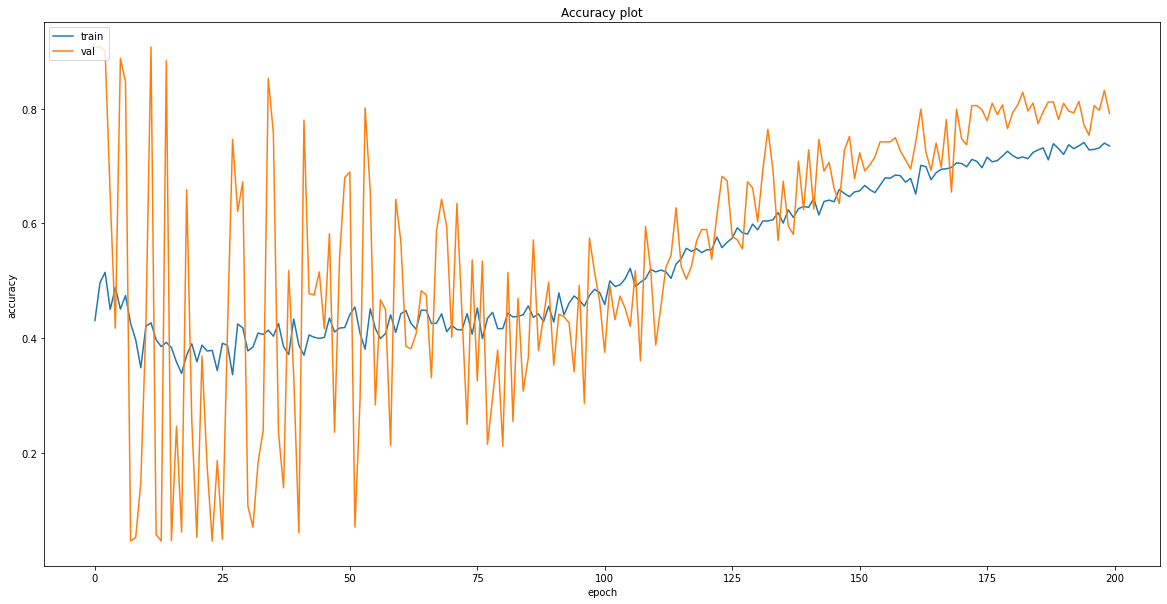

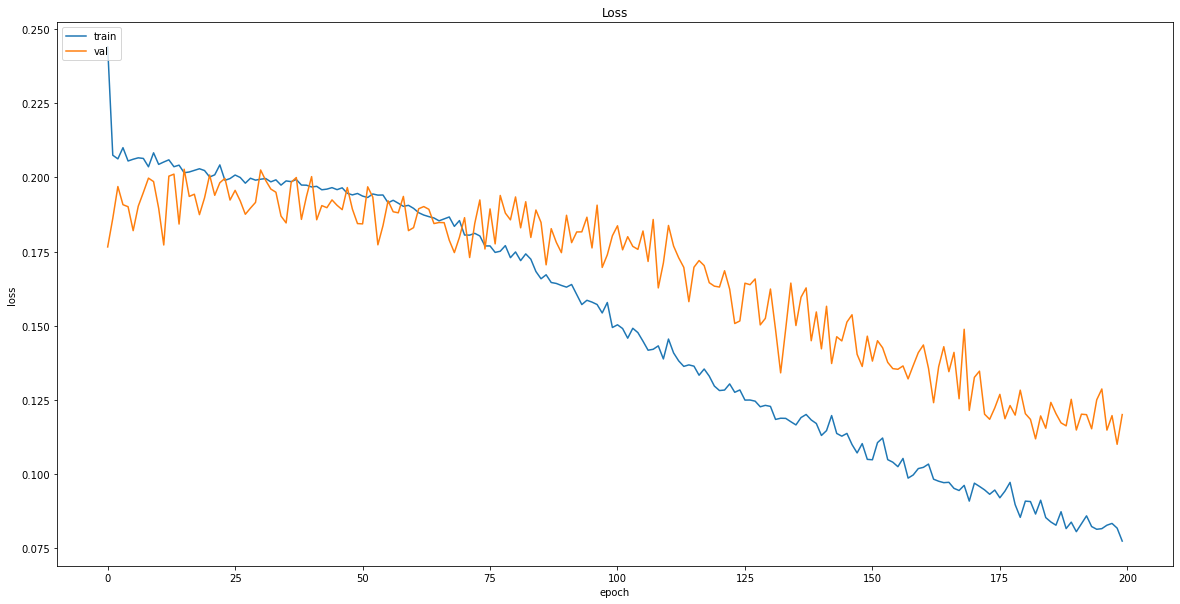

In [802]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [803]:
# Save model
model.save("models/{}".format('axl_image_cnn_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/axl_image_cnn_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [804]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-12-06        12.27  12.266266 -43.949026  234486200.0     2.0
2018-12-07        11.98  12.222225 -62.420426  231459100.0     2.0
2018-12-10        11.33  12.084959 -93.678180  229051600.0     2.0
2018-12-11        11.38  11.976504 -73.831760  231349000.0     2.0
2018-12-12        11.32  11.875503 -76.635518  229316700.0     2.0

In [805]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [806]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [807]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
X = X/255
y = np.array(y)

In [808]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [809]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1197 - accuracy: 0.7936 - mean_squared_error: 1.7274 - weighted_accuracy: 0.7936 - weighted_mean_squared_error: 1.7274
Test loss: 0.11969614773988724
Test accuracy: 0.7935779690742493


In [810]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 15, 2: 187, 0: 16})

In [811]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [812]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-812-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-812-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-812-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        14.01  14.312907 -83.060094  17347800.0     2.0   
2019-02-12        14.34  14.266306 -68.852439  19189100.0     2.0   
2019-02-13        14.45  14.277643 -50.819664  21493700.0     2.0   
2019-02-14        14.70  14.304160 -44.808757  23008200.0     2.0   
2019-02-15        16.83  14.365058 -31.147561  25735200.0     2.0   

            predictions  actual  
Date                             
2019-02-11            1       2  
2019-02-12            1       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            0       2

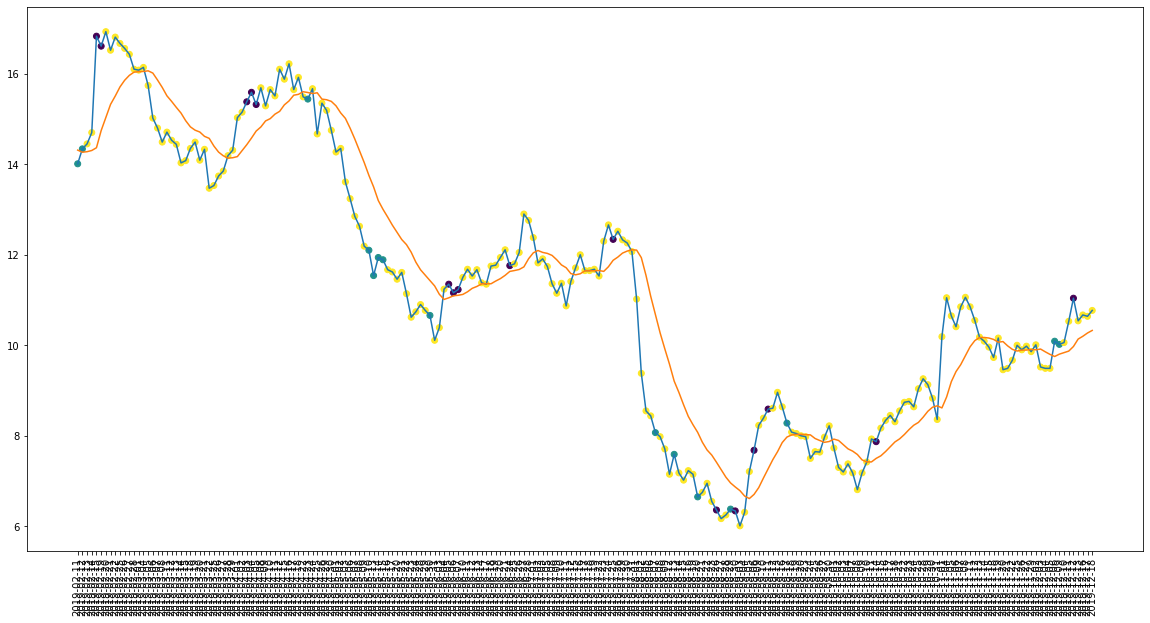

In [813]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

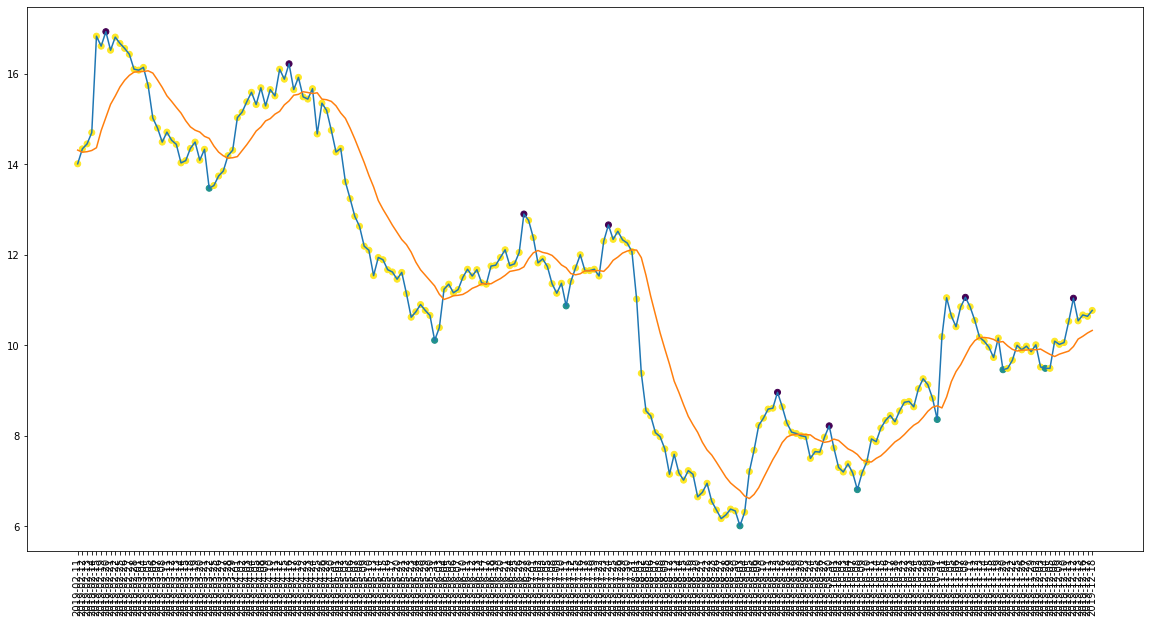

In [814]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [815]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 15
actual holds but predicted sell: 15
actual predicted holds: 172
Percentage buys correct: 0.0%
Percentage sells correct: 12.5%
Percentage holds correct: 85.14851485148515%
actual buys: 8
actual sells: 8
actual holds: 202


In [816]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 46.666666666666664%
Percentage sells correct: 43.75%
Percentage holds correct: 85.48387096774194%


In [817]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.010000228881836
Shares owned at the moment: 711
Cash capital at the moment: $11.496784317492711


Price increase from previously bought: 19.799029818276615%
Share price: $16.829999923706055
Shares owned at the moment: 0
Cash capital at the moment: $11944.719872721671


Share price: $15.4399995803833
Shares owned at the moment: 771
Cash capital at the moment: $7.743537135838778


Stop Loss Activated!

Share price: $14.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $11287.209528296708


Share price: $12.100000381469727
Shares owned at the moment: 930
Cash capital at the moment: $3.2634225542533386


Stop Loss Activated!

Share price: $11.539999961853027
Shares owned at the moment: 0
Cash capital at the moment: $10705.949837175129


Share price: $11.539999961853027
Shares owned at the moment: 925
Cash capital at the moment: $2.0949975581152103


Stop Loss Activated!

Share price: $11.140000343322754
Shares owned at the moment: 0
Cash capital at 

In [818]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


### recession

In [2]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

NameError: name 'pd' is not defined

In [820]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_25_price = []
data_25_willr = []
data_25_ema = []
data_25_obv = []
count = 0

for i in df2.values:
    if count == 24:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_price_arr = min_max_scaler.fit_transform(data_25_price)
        data_25_ema_arr = min_max_scaler.fit_transform(data_25_ema)
        data_25_willr_arr = min_max_scaler.fit_transform(data_25_willr)
        data_25_obv_arr = min_max_scaler.fit_transform(data_25_obv)
        price_data.append(data_25_price_arr)
        willr_data.append(data_25_willr_arr)
        ema_data.append(data_25_ema_arr)
        obv_data.append(data_25_obv_arr)
        labels.append(i[-1])
        data_25_price = data_25_price[1:]
        data_25_willr = data_25_willr[1:]
        data_25_obv = data_25_obv[1:]
        data_25_ema = data_25_ema[1:]
    
    else:
        data_25_price.append([i[0]])
        data_25_ema.append([i[1]])
        data_25_willr.append([i[2]])
        data_25_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [821]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [822]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [823]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [824]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1208 - accuracy: 0.7763 - mean_squared_error: 1.7218 - weighted_accuracy: 0.7763 - weighted_mean_squared_error: 1.7218
Test loss: 0.12080448120832443
Test accuracy: 0.77625572681427


In [825]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 187, 1: 18, 0: 14})

In [826]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [1]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

NameError: name 'df2' is not defined

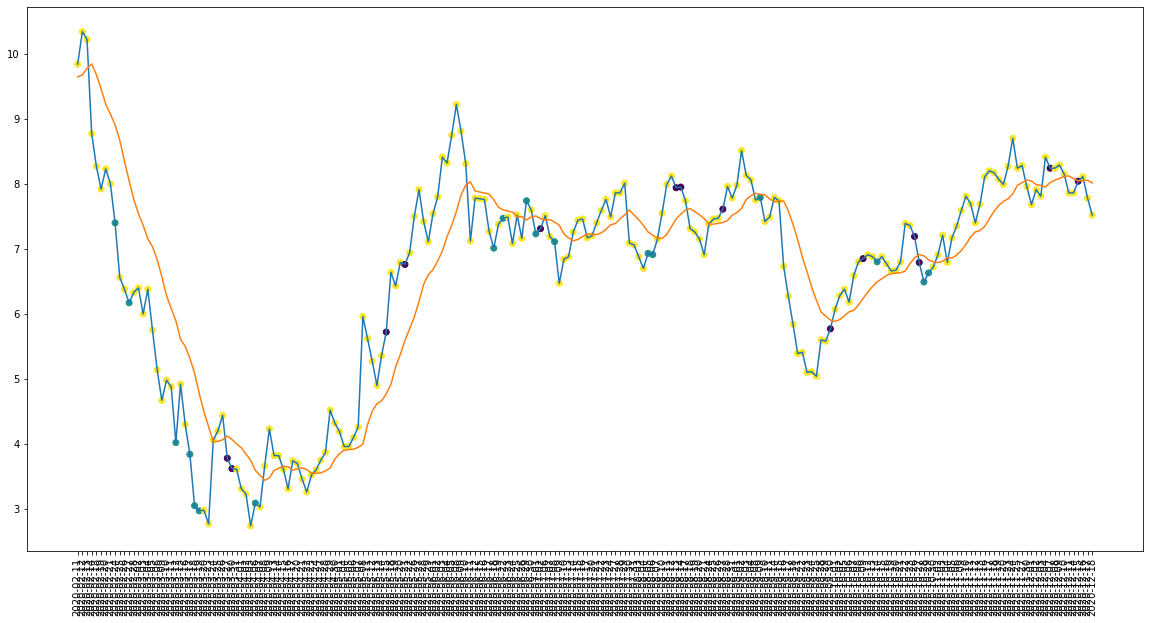

In [828]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

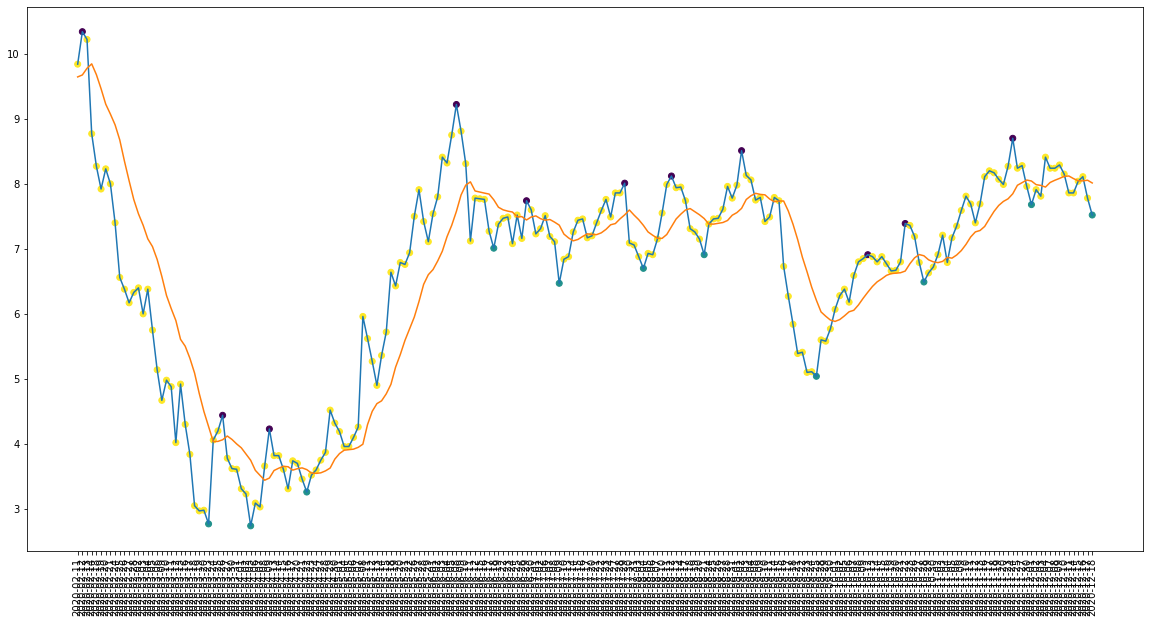

In [829]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [830]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 15
actual holds but predicted sell: 14
actual predicted holds: 168
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 0.0%
Percentage holds correct: 85.27918781725889%
actual buys: 11
actual sells: 11
actual holds: 197


In [831]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 72.22222222222223%
Percentage sells correct: 57.142857142857146%
Percentage holds correct: 83.87096774193549%


In [832]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $7.400000095367432
Shares owned at the moment: 1347
Cash capital at the moment: $4.788421186804044


Stop Loss Activated!

Share price: $6.559999942779541
Shares owned at the moment: 0
Cash capital at the moment: $8816.808464322805


Share price: $6.170000076293945
Shares owned at the moment: 1425
Cash capital at the moment: $0.37966780495480634


Stop Loss Activated!

Share price: $6.0
Shares owned at the moment: 0
Cash capital at the moment: $8526.867167804954


Share price: $4.019999980926514
Shares owned at the moment: 2115
Cash capital at the moment: $1.1858832563139003


Stop Loss Activated!

Share price: $3.839999914169312
Shares owned at the moment: 0
Cash capital at the moment: $8100.4513022236215


Share price: $3.839999914169312
Shares owned at the moment: 2103
Cash capital at the moment: $2.7238032219383967


Stop Loss Activated!

Share price: $3.049999952316284
Shares owned at the moment: 0
Cash capital at the moment: $6399.2347907188505


Share price: $3.0499

In [833]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%
